# Projet de machine learning en utilsant le processus CRISP-DM
Sources utilisées dans le projet :
- https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
- Smartphone and Smartwatch-Based Biometrics Using Activities of Daily Living. IEEE Access, 7:133190-133202, Sept. 2019.

## Compréhension du problème

Il s'agira de concevoir, développer et évaluer un système d’apprentissage machine dans un projet scolaire. Le projet a donc pour vocation d'appliquer les méthodes d'apprentissage vues en cours à travers le processus CRISP-DM. Ce projet est réalisé à deux personnes. Dans cette partie on s'interessera a classifier des activités à partir d'un smartphone et d'une smartwatch sur un individu à la fois.  
Python sera ici utilisé avec l'outil JupyterLab pour la rédaction du rapport. Les modules propres à Python tels que Scikit-Learn et Pandas seront ici à l'emploie.

## Compréhension des données
### Mise en place

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "personal_model"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Récupération des données

In [2]:
import zipfile
import urllib

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/"
WISDM_PATH = os.path.join("datasets", "wisdm")
WISDM_URL = DOWNLOAD_ROOT + "wisdm-dataset.zip"

def fetch_wisdm_data(wisdm_url=WISDM_URL, wisdm_path=WISDM_PATH):
    if not os.path.isdir(wisdm_path):
        os.makedirs(wisdm_path)
    zip_path = os.path.join(wisdm_path, "wisdm-dataset.zip")
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(wisdm_url, zip_path)
    uncompressed_path = os.path.join(wisdm_path, "wisdm-dataset")
    if not os.path.isdir(uncompressed_path):
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(wisdm_path)

In [3]:
fetch_wisdm_data()

In [4]:
def load_raw_wisdm_data(subjectId, device, sensor, wisdm_path=WISDM_PATH):
    """
        Charge les données brutes.
        device : 'phone' ou 'watch'
        sensor : 'accel' ou 'gyro'
    """
    subjectIdStr = str(subjectId)
    rawPath = os.path.join(WISDM_PATH,'wisdm-dataset','raw',device,sensor,'data_'+subjectIdStr+'_'+sensor+'_'+device+'.txt')
    f = open(rawPath, 'r')
    lines = f.readlines()
    data=[[],[],[]]
    timestamp=[]
    series={}
    activities=[]
    for l in lines:
        spt=l.split(',')
        activities.append(spt[1])
        data[0].append(float(spt[3]))
        data[1].append(float(spt[4]))
        data2=spt[5].split(';')[0]
        data[2].append(float(data2))
        timestamp.append(int(spt[2]))
    f.close()
    #d={'activity': activities, 'x': data[0], 'y': data[1], 'z': data[2]}
    d={'time': timestamp, 'activity': activities, 'x': data[0], 'y': data[1], 'z': data[2]}
    df=pd.DataFrame(data=d, index=pd.to_datetime(timestamp))
    #df=pd.DataFrame(data=d)
    
    activities = df['activity'].unique()
    for activity in activities:
        serie = df.loc[df['activity']==activity]
        timestamp=serie['time'].to_numpy()
        timestamp = [(x-timestamp[0])*10**-9 for x in timestamp]
        df.loc[df['activity']==activity, 'time']=timestamp
    return df

In [5]:
# library for reading arff file
# You can install it via 'pip install liac-arff'
# https://pypi.org/project/liac-arff/ for more informations
import arff
import pandas as pd

def load_wisdm_data(subjectId, device, sensor, wisdm_path=WISDM_PATH):
    """
        Charge les données pré-traitées.
        device : 'phone' ou 'watch'
        sensor : 'accel' ou 'gyro'
    """
    subjectIdStr = str(subjectId)
    arffPath = os.path.join(WISDM_PATH,'wisdm-dataset','arff_files',device,sensor,'data_'+subjectIdStr+'_'+sensor+'_'+device+'.arff')
    f=open(arffPath, 'r')
    data = arff.load(f)
    attributesName = [data['attributes'][i][0] for i in range (len(data['attributes']))]
    dataFrame = pd.DataFrame(data = data['data'], columns=attributesName)
    f.close()
    return dataFrame

### Description des données

Les données sont décrites dans le fichier WISDM-dataset-description.pdf du jeu de données précédemment téléchargé.
Ce jeu de données est composé de données provenant de 51 personnes à qui on a demandé de réaliser 18 tâches de 3 minutes. Chacun des sujets a une smartwatch attachée au poignet de leurs mains dominantes et un smartphone dans leurs poches. Les données collectées proviennent des girocscopes et des accéléromètres de la montre et du téléphone.

Un pré-traitement des données a déja été fait dans le jeu de données. Il en résulte un des données etiquetées sur les exemples au lieu de données étiquetées sur une série temporelle. Le traitement pour faire cela consiste à utiliser une fonction porte de 10s sur chaque série temporelle de données.

Les chercheurs ont rencontrés des problèmes pour la collecte des données du gyroscope du téléphone. Ces données ci ne sont donc pas fiables et seront manipulées seulement pour illustrer le problème.

### Les données brutes

Saving figure Données brutes


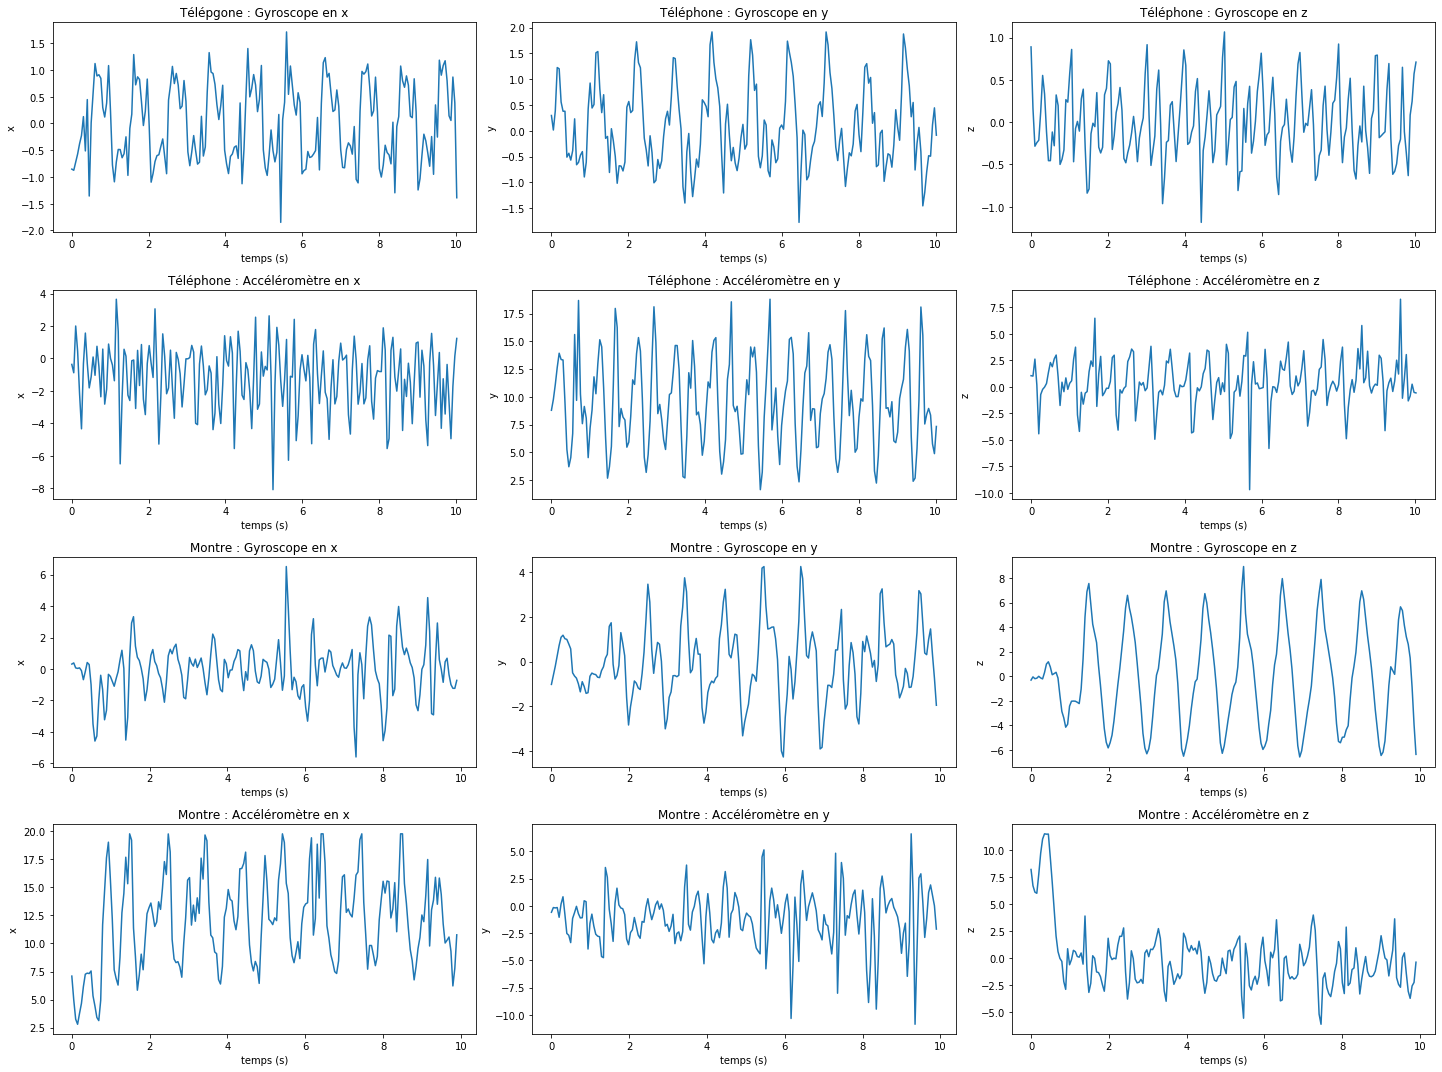

In [6]:
series_phone_gyro=load_raw_wisdm_data(1600, 'phone', 'gyro')
series_phone_accel=load_raw_wisdm_data(1600, 'phone', 'accel')
series_watch_accel=load_raw_wisdm_data(1600, 'watch', 'accel')
series_watch_gyro=load_raw_wisdm_data(1600, 'watch', 'gyro')

serie_A_phone_gyro = series_phone_gyro.loc[series_phone_gyro['activity']=='A'][0:200]
serie_A_phone_accel = series_phone_accel.loc[series_phone_accel['activity']=='A'][0:200]
serie_A_watch_accel = series_watch_accel.loc[series_watch_accel['activity']=='A'][0:200]
serie_A_watch_gyro = series_watch_gyro.loc[series_watch_gyro['activity']=='A'][0:200]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
plt.subplots_adjust(hspace = 0.4)

#Ligne 1
axs[0, 0].set_title('Télépgone : Gyroscope en x')
axs[0, 0].set_xlabel('temps (s)')
axs[0, 0].set_ylabel('x')
axs[0, 0].plot(serie_A_phone_gyro['time'],serie_A_phone_gyro['x'])

plt.subplot(432)
plt.title('Téléphone : Gyroscope en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(serie_A_phone_gyro['time'],serie_A_phone_gyro['y'])

plt.subplot(433)
plt.title('Téléphone : Gyroscope en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(serie_A_phone_gyro['time'],serie_A_phone_gyro['z'])

#Ligne 2
plt.subplot(434)
plt.title('Téléphone : Accéléromètre en x')
plt.xlabel('temps (s)')
plt.ylabel('x')
plt.plot(serie_A_phone_accel['time'],serie_A_phone_accel['x'])

plt.subplot(435)
plt.title('Téléphone : Accéléromètre en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(serie_A_phone_accel['time'],serie_A_phone_accel['y'])

plt.subplot(436)
plt.title('Téléphone : Accéléromètre en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(serie_A_phone_accel['time'],serie_A_phone_accel['z'])

#Ligne 3
plt.subplot(437)
plt.title('Montre : Gyroscope en x')
plt.xlabel('temps (s)')
plt.ylabel('x')
plt.plot(serie_A_watch_gyro['time'],serie_A_watch_gyro['x'])

plt.subplot(438)
plt.title('Montre : Gyroscope en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(serie_A_watch_gyro['time'],serie_A_watch_gyro['y'])

plt.subplot(439)
plt.title('Montre : Gyroscope en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(serie_A_watch_gyro['time'],serie_A_watch_gyro['z'])

#Ligne 1
axs[3, 0].set_title('Montre : Accéléromètre en x')
axs[3, 0].set_xlabel('temps (s)')
axs[3, 0].set_ylabel('x')
axs[3, 0].plot(serie_A_watch_accel['time'],serie_A_watch_accel['x'])

axs[3, 1].set_title('Montre : Accéléromètre en y')
axs[3, 1].set_xlabel('temps (s)')
axs[3, 1].set_ylabel('y')
axs[3, 1].plot(serie_A_watch_accel['time'],serie_A_watch_accel['y'])

axs[3, 2].set_title('Montre : Accéléromètre en z')
axs[3, 2].set_xlabel('temps (s)')
axs[3, 2].set_ylabel('z')
axs[3, 2].plot(serie_A_watch_accel['time'],serie_A_watch_accel['z'])

save_fig("Données brutes")

plt.show()

#### Exemple de spectre

Saving figure Exemple de spectre


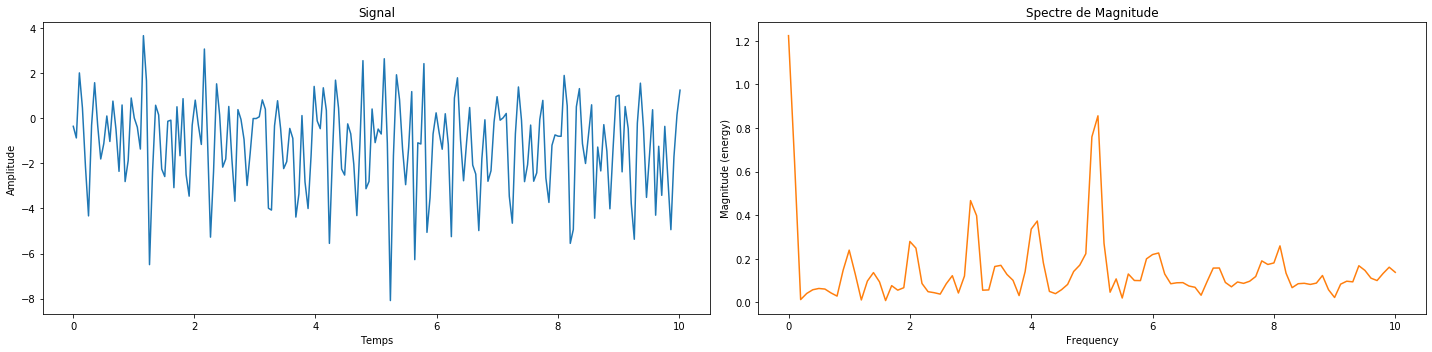

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axes[0].set_title("Signal")
axes[0].plot(serie_A_phone_accel['time'], serie_A_phone_accel['x'], color='C0')
axes[0].set_xlabel("Temps")
axes[0].set_ylabel("Amplitude")

axes[1].set_title("Spectre de Magnitude")
axes[1].magnitude_spectrum(serie_A_phone_accel['x'],Fs=20, color='C1')

save_fig("Exemple de spectre")

plt.show()

Ce spectre de magnitude à était réalisé à titre d'exemple. Il est possible d'extraire des caractéristiques importantes de ce spectre comme les piques de fréquence par exemple.

### Corrélation entre les signaux

On s'interesse ici à la corrélation entre les différents signaux et pour chaque activités.  
Les corrélations suivantes ont été calculées pour le sujet 1600 uniquement et sur le capteur en x seulement par soucis de lisibilité.

In [8]:
ACTIVITIES_CODE=[chr(i) for i in range(ord('A'),ord('S')+1)]
#Il n'y a pas d'activité N
ACTIVITIES_CODE.remove('N')

for code in ACTIVITIES_CODE:

    serie_code_phone_gyro = series_phone_gyro.loc[series_phone_gyro['activity']==code]
    serie_code_phone_accel = series_phone_accel.loc[series_phone_accel['activity']==code]
    serie_code_watch_accel = series_watch_accel.loc[series_watch_accel['activity']==code]
    serie_code_watch_gyro = series_watch_gyro.loc[series_watch_gyro['activity']==code]

    length1=len(serie_code_phone_gyro)
    length2=len(serie_code_phone_accel)
    length3=len(serie_code_watch_accel)
    length4=len(serie_code_watch_gyro)
    
    #Les séries ayant des longueurs différentes (Chaque activité n'a pas la même durée), on prend la longueur minimum
    length=min(length1,length2,length3,length4)

    x=serie_code_phone_accel['x'].head(length)
    y=serie_code_phone_gyro['x'].head(length)
    z=serie_code_watch_accel['x'].head(length)
    w=serie_code_watch_gyro['x'].head(length)
    
    df=pd.DataFrame({'phone_accel':x.values, 'phone_gyro':y.values, 'watch_accel':z.values, 'watch_gyro':w.values})
    df=df.corr()
    print("Actvité : ",code," : ","\n",df,'\n')

Actvité :  A  :  
              phone_accel  phone_gyro  watch_accel  watch_gyro
phone_accel     1.000000   -0.120744    -0.016635   -0.012606
phone_gyro     -0.120744    1.000000     0.047844    0.044062
watch_accel    -0.016635    0.047844     1.000000    0.059629
watch_gyro     -0.012606    0.044062     0.059629    1.000000 

Actvité :  B  :  
              phone_accel  phone_gyro  watch_accel  watch_gyro
phone_accel     1.000000   -0.131543     0.000069   -0.008299
phone_gyro     -0.131543    1.000000    -0.012437   -0.004088
watch_accel     0.000069   -0.012437     1.000000   -0.262886
watch_gyro     -0.008299   -0.004088    -0.262886    1.000000 

Actvité :  C  :  
              phone_accel  phone_gyro  watch_accel  watch_gyro
phone_accel     1.000000   -0.160703    -0.033941    0.051982
phone_gyro     -0.160703    1.000000     0.047608   -0.077946
watch_accel    -0.033941    0.047608     1.000000   -0.113491
watch_gyro      0.051982   -0.077946    -0.113491    1.000000 

Actvité

Aucune corrélation ne semble se dégager de ces matrices de corrélation. On ne peut donc rien déduire sur la similitude des signaux et on gardera tous les signaux pour la modélisation.

### Les donées prétraitées

#### Données de l'accéléromètre du téléphone

In [9]:
pd.set_option('display.max_columns', 20)
subject1600_phone_accel = load_wisdm_data(1600, 'phone', 'accel')
subject1600_phone_accel.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.235,0.470,0.275,0.020,0.000,0.0,0.0,0.0,0.0,...,0.486106,0.479859,-0.550668,0.049864,0.121354,-0.251024,0.164468,-0.110722,10.05180,1600
1,A,0.275,0.440,0.270,0.015,0.000,0.0,0.0,0.0,0.0,...,0.479571,0.473409,-0.633171,0.072129,0.161492,-0.386416,0.215680,-0.034375,10.11710,1600
2,A,0.320,0.430,0.245,0.000,0.005,0.0,0.0,0.0,0.0,...,0.483005,0.476798,-0.659493,0.087043,0.162157,-0.325151,0.272380,-0.077274,9.98384,1600
3,A,0.315,0.495,0.185,0.005,0.000,0.0,0.0,0.0,0.0,...,0.480711,0.474534,-0.712081,0.003810,0.210015,-0.364285,0.203131,0.015328,10.10600,1600
4,A,0.215,0.455,0.325,0.005,0.000,0.0,0.0,0.0,0.0,...,0.468836,0.462811,-0.534933,0.047553,0.275833,-0.216423,0.238500,-0.009870,10.05210,1600


In [10]:
pd.set_option('display.max_columns', 13)
subject1600_phone_accel.describe()

,X0,X1,X2,X3,X4,X5,...,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,...,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,0.128816,0.264517,0.319969,0.235031,0.051277,0.000312,...,0.558735,0.595346,-0.100686,0.105777,-0.421535,9.697830
std,0.214657,0.335906,0.415449,0.402267,0.206116,0.001499,...,0.579945,0.550815,0.365069,0.421341,0.391955,0.460055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.997769,-0.952187,-0.999753,-0.986312,-0.999803,9.171570
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.098196,0.151871,-0.322235,-0.179483,-0.738426,9.327910
50%,0.000000,0.000000,0.120000,0.005000,0.000000,0.000000,...,0.965633,0.994368,-0.076160,0.100942,-0.557509,9.637580
75%,0.240000,0.520000,0.905000,0.125000,0.000000,0.000000,...,0.999106,0.999577,0.127908,0.442266,-0.053193,9.985840
max,1.000000,1.000000,1.000000,1.000000,0.995000,0.010000,...,0.999951,0.999939,0.975860,0.999756,0.565919,11.428800


On voit déja que les données ne sont pas normalisées car le min et le max ont des valeurs différentes selon les données.

## Séléction des données

### Histogramme des données du sujet 1600

Saving figure Histogramme des données du sujet 1600


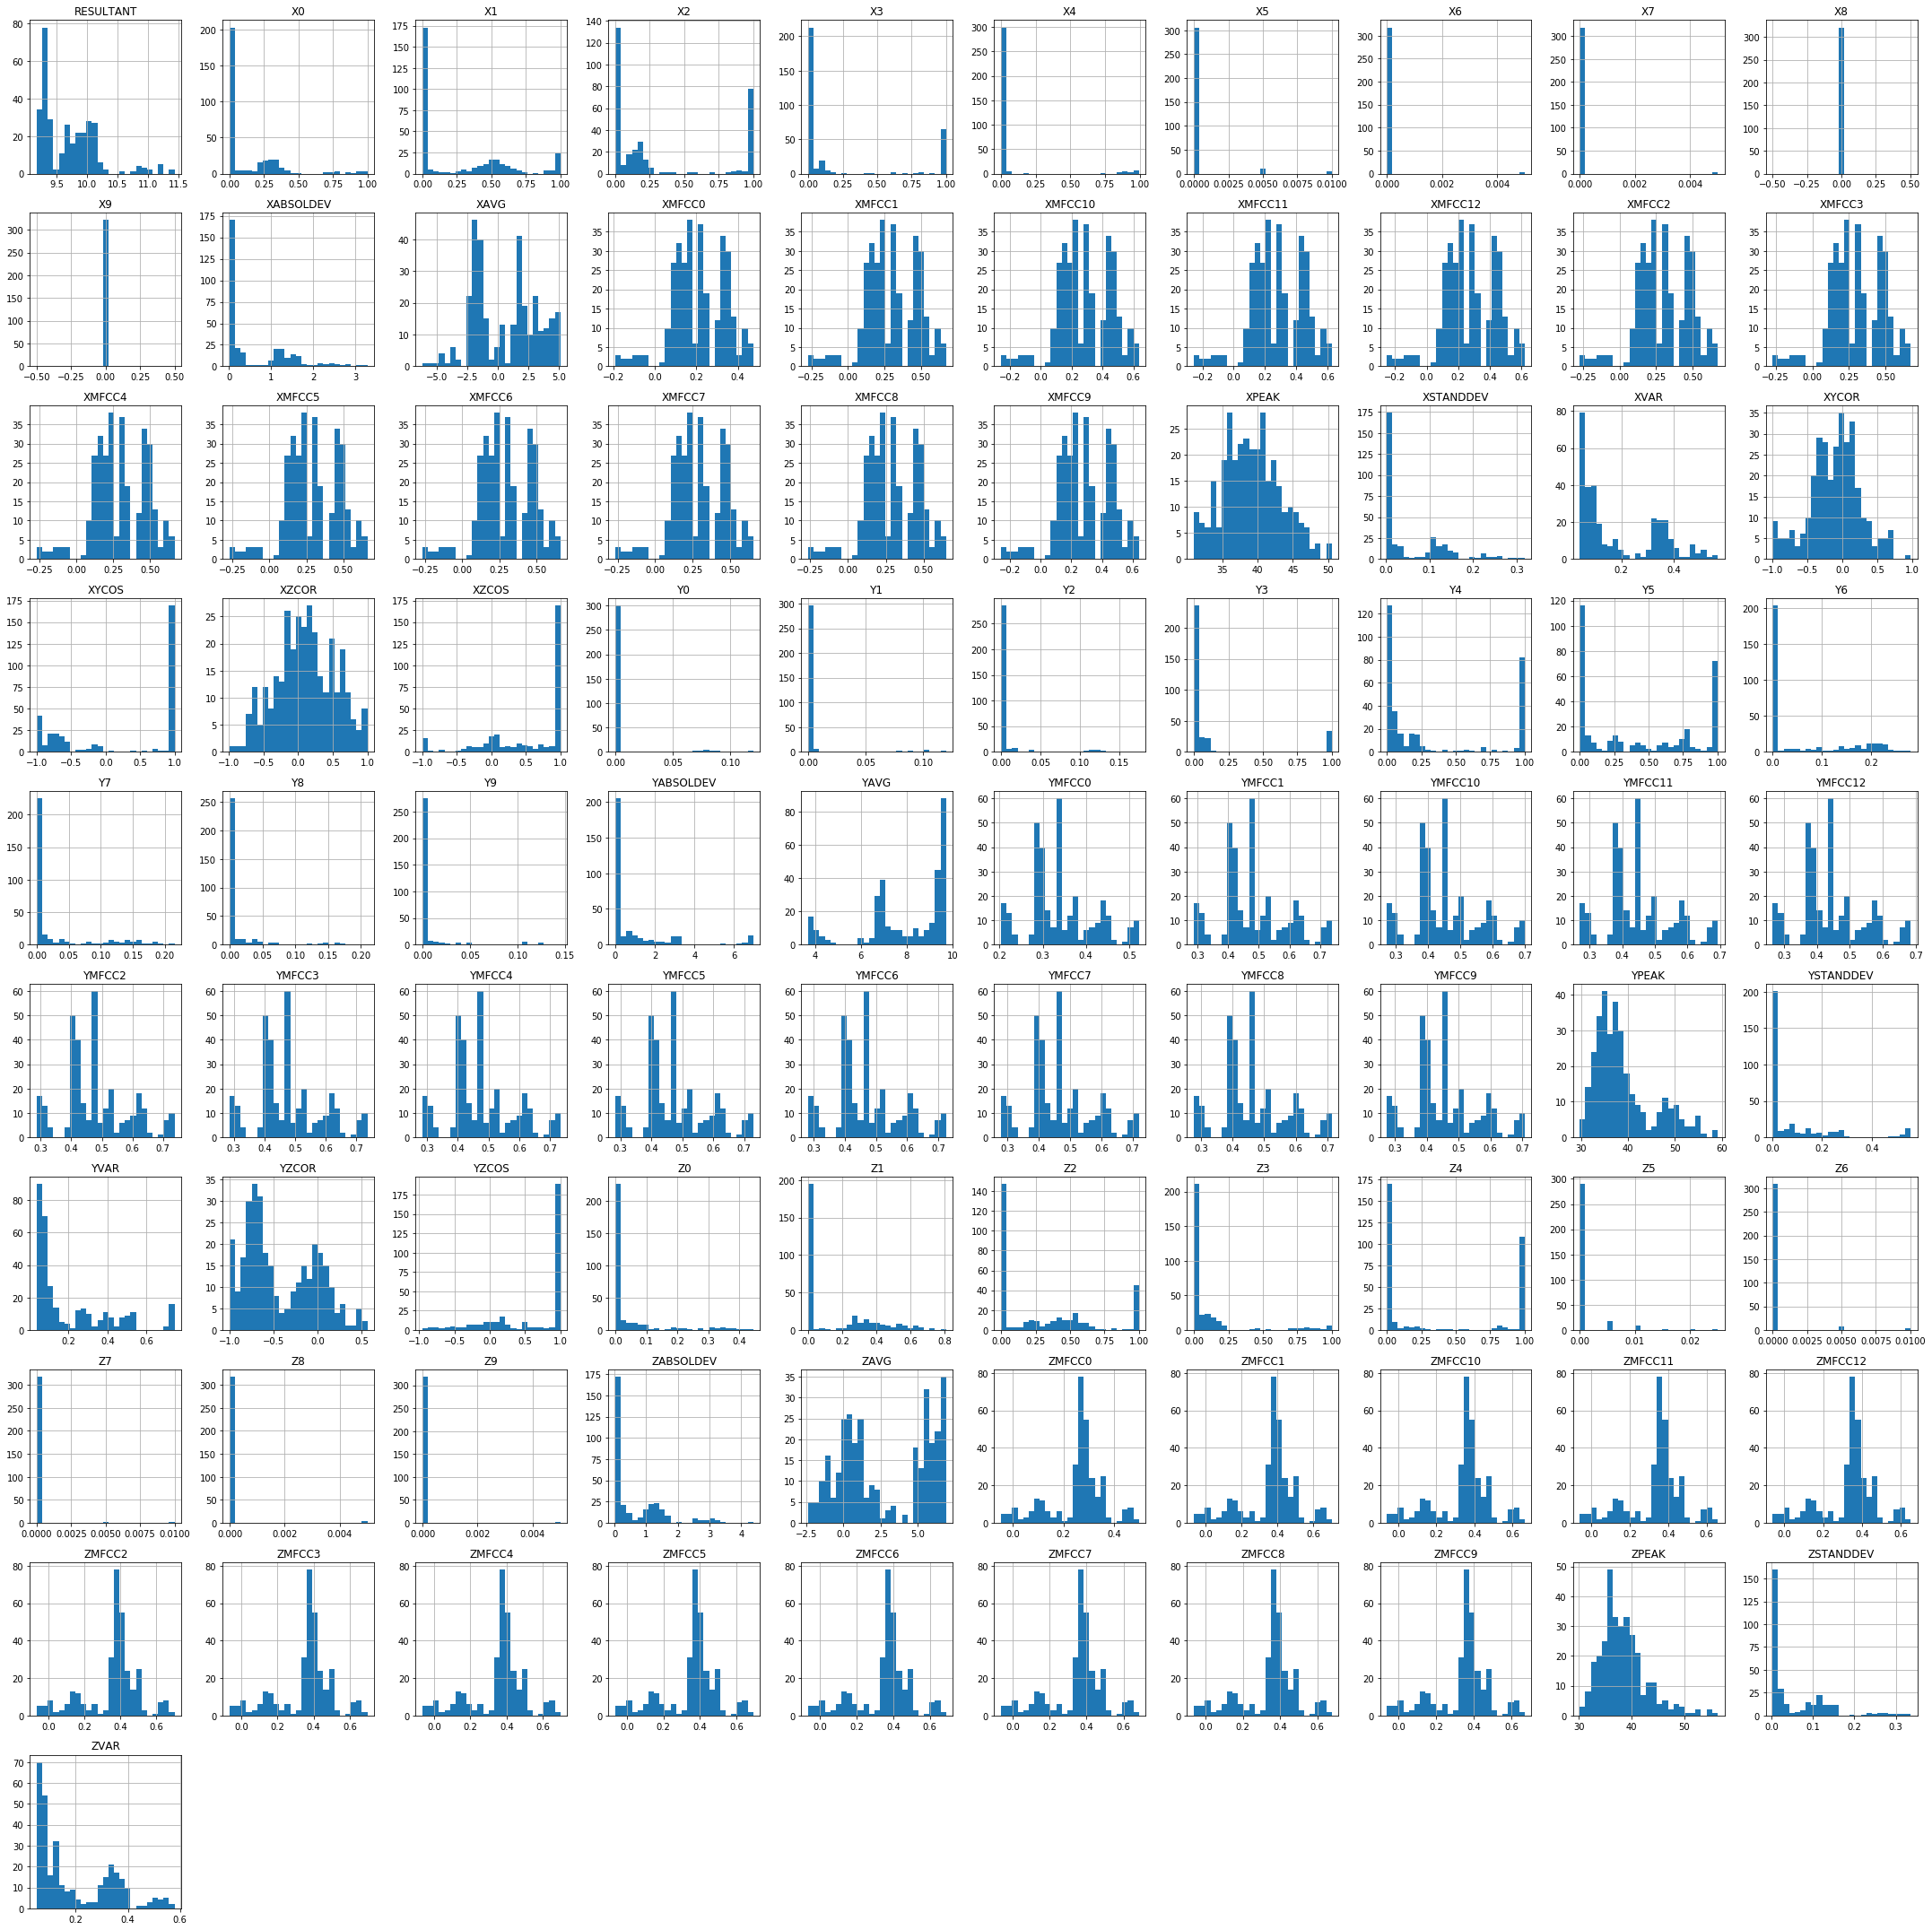

In [11]:
subject1600_phone_accel.hist(bins = 25, figsize=(30,30))
save_fig("Histogramme des données du sujet 1600")
plt.show()

On remarque dans l'histogramme que certains attributs comme X0 et X3 n'ont que très peu de dispersion. D'autres n'ont aucune dispersion comme X7 et X8 qui sont nuls tout le temps. On va essayer de voir si ces attributs sont utiles ou si on peut les enlever pour la suite.  
Les histogrammes XMFCC{0-12}, YMFCC{0-12} et ZMFCC{0-12} semblent similaires, on peut regarder le coefficient de corrélation entre ces derniers pour connaitre le niveau de similitude de ces attributs.

### Corrélation des attributs de puissance spéctrales (XMFCC, YMFCC, ZMFCC) du sujet 1600

Saving figure Corrélation des attributs de puissance spéctrales


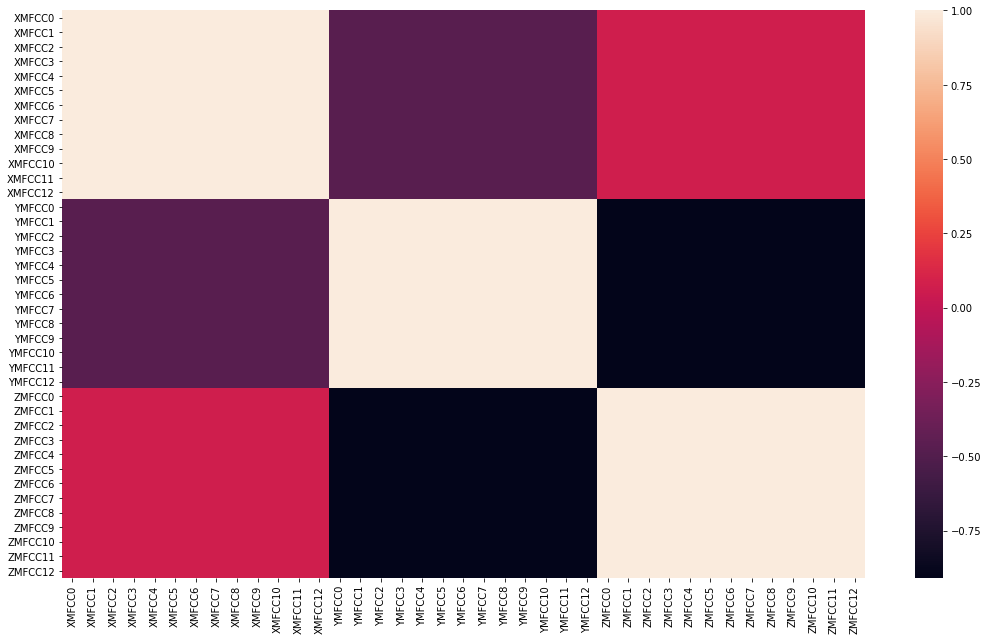

In [12]:
corr_matrix = subject1600_phone_accel.corr()
corr_matrix = corr_matrix**2

elements1=['XMFCC','YMFCC','ZMFCC']
attributes=[e+str(i) for e in elements1 for i in range (0,13)]

power_spectrum_corr=corr_matrix[attributes].loc[attributes]

fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(power_spectrum_corr.corr())

save_fig("Corrélation des attributs de puissance spéctrales")

plt.show()

Les attributs XMFCC{0-12} sont effectivement corrélés avec un coefficient égal à 1. Il ne semble pas important de garder tous ces attributs pour le sujet 1600. Il en est de même pour les attributs YMFCC{0-12} et ZMFCC{0-12}.  
On va alors regarder si ces attributs sont inutiles pour tous les sujets ou s'ils le sont seulement pour le sujet 1600 afin de savoir si on peut les retirer.

### Histogramme des données de tous les sujets

In [13]:
import random
import pandas as pd

SUBJECT_NUMBER = 51
FIRST_SUBJECT_ID=1600
SUBJECTSID = [i+FIRST_SUBJECT_ID for i in range(SUBJECT_NUMBER)]
#Le sujet 1614 n'est pas dans la liste ...
SUBJECTSID.remove(1614)

def load_multiple_wisdm_data(subjectToExtractNumber, device, sensor):
    #for reproductibility
    random.seed(1)
    subjectsToExtract = random.sample(SUBJECTSID,subjectToExtractNumber)
    
    subject = load_wisdm_data(1600, device, sensor) 
    subjectsDf = pd.DataFrame(columns=subject.columns)
    for i in range(subjectToExtractNumber):
        subjectDf = load_wisdm_data(subjectsToExtract[i], device, sensor)
        subjectsDf = subjectsDf.append(subjectDf)
    return subjectsDf

Saving figure Histogramme des données de tous les sujets


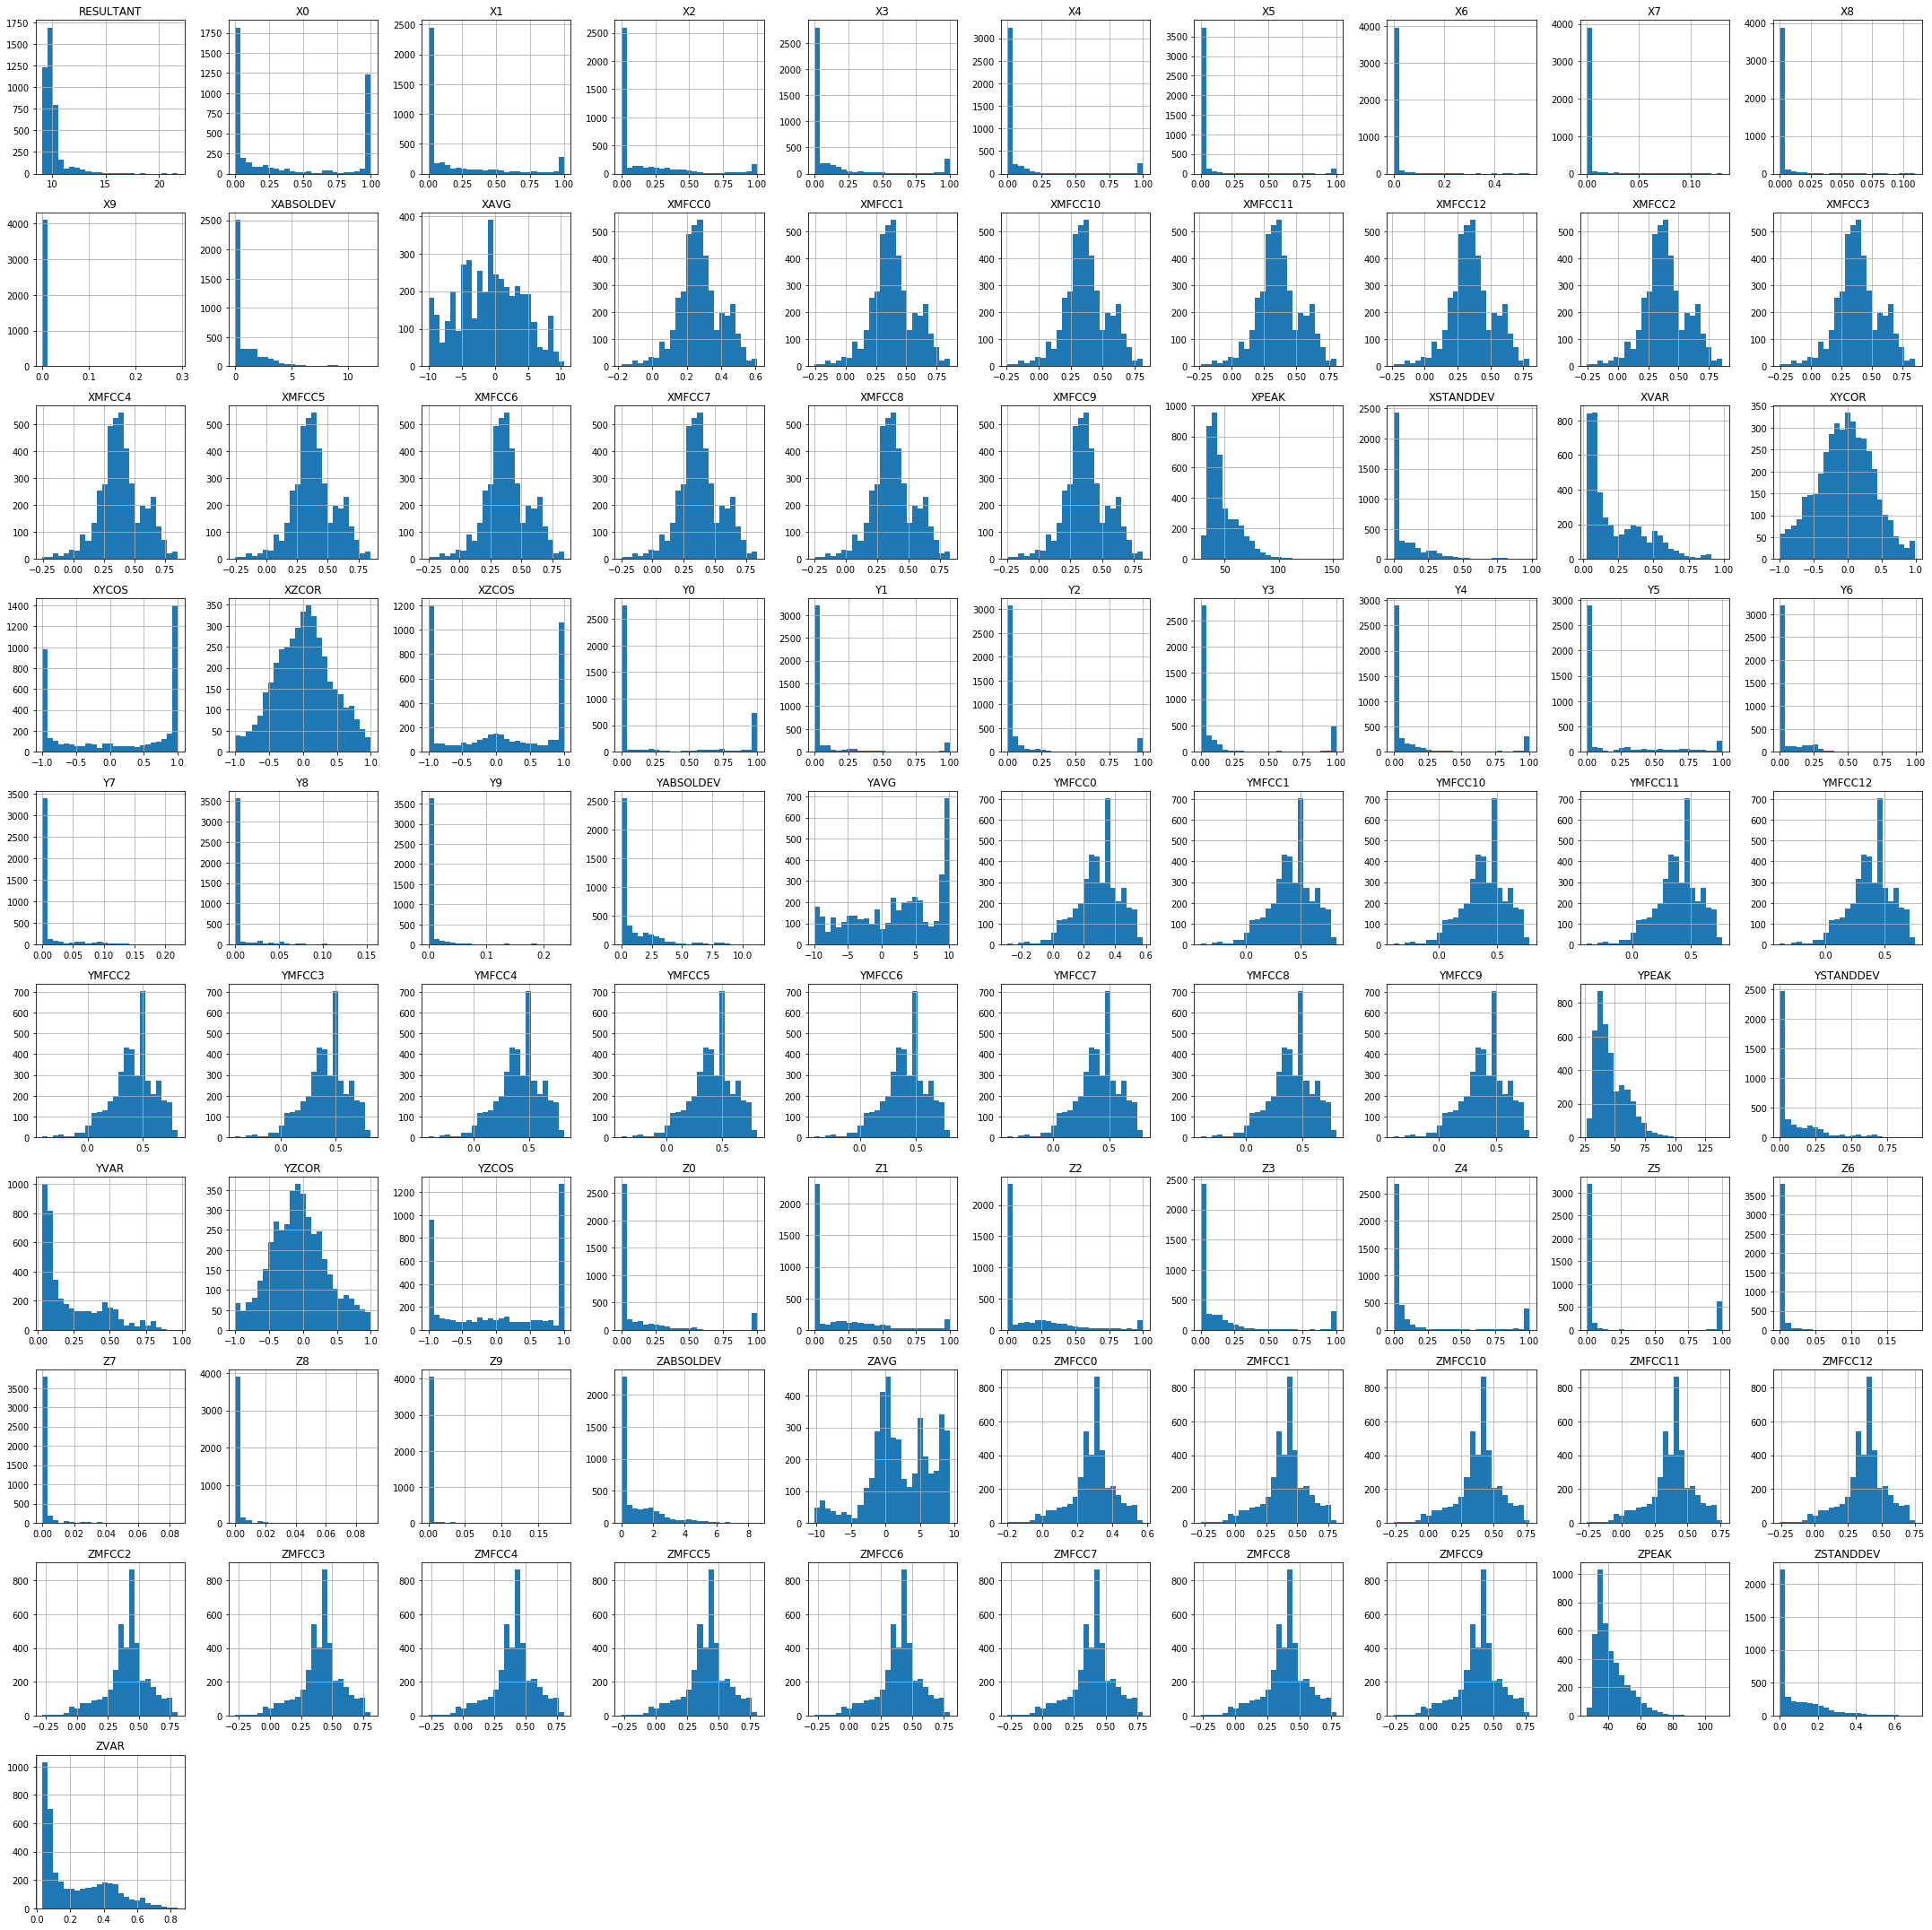

In [14]:
subjects_phone_accel = load_multiple_wisdm_data(10, 'phone', 'accel')
subjects_phone_accel.hist(bins = 25, figsize=(30,30))

save_fig("Histogramme des données de tous les sujets")

plt.show()

La tendance se confirme, les attributs de la MFCC (Mel-frequency cepstrum) que sont les XMFCC{0-12} les YMFCC{0-12} et les ZMFCC{0-12} possède chacun les mêmes histogrammes. Il ne semble donc pas pertinent de garder tous ces attributs pour l'apprentissage. Nous pourrons par la suite en sélectionner seulement un de chaque (XMFCC0, YMFCC0 et ZMFCC0 par exemple).
Les X{6-9}, Y{6-9} et Z{6-9} n'ont que très peu, voir pas, de dispersions et il pourrait être intéressant de voir s'ils sont vraiment nécessaires à la réalisation d'un classifieur performant.

In [15]:
t1=['XMFCC','YMFCC','ZMFCC']
attributes1=[e+str(i) for e in t1 for i in range (1,13)]
not_relevant_features = {}
not_relevant_features["similar"]=attributes1

t2=['X','Y','Z']
attributes2=[e+str(i) for e in t2 for i in range (6,10)]
not_relevant_features["low_variance"]=attributes2

### Histogramme des données réduit (sans las attributs de la MFCC)

Saving figure Histogramme des données réduit 1


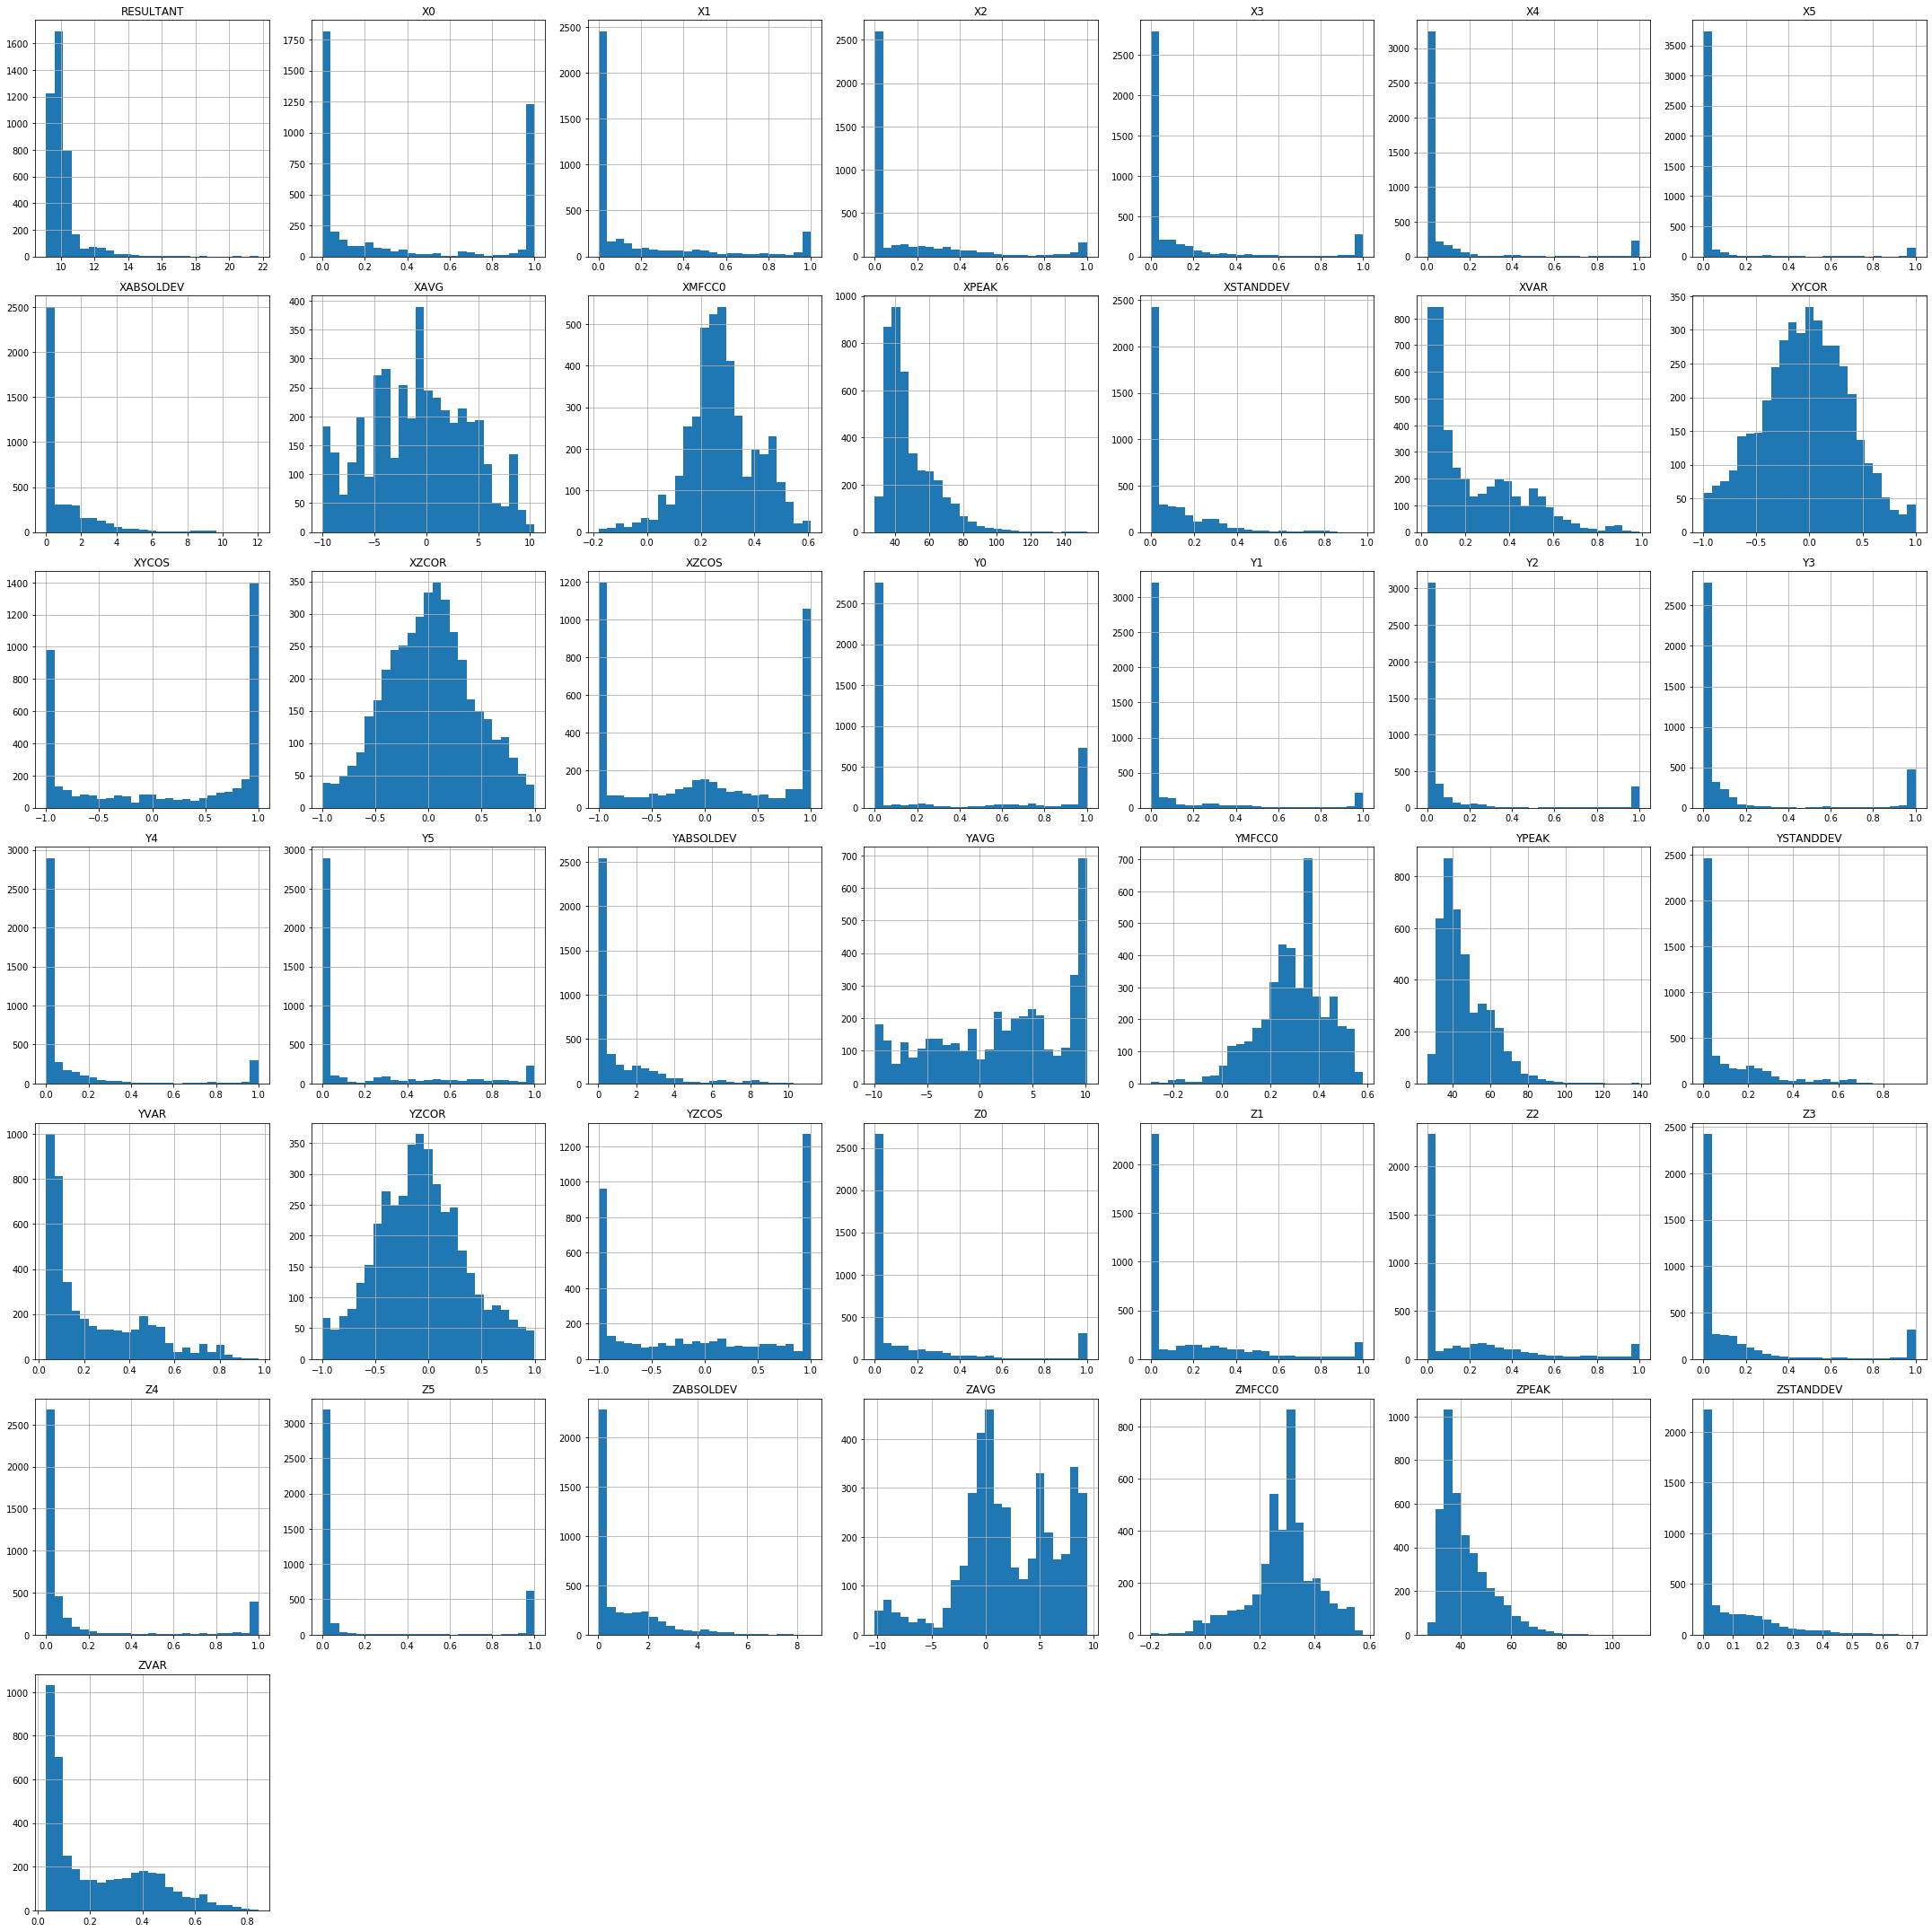

In [16]:
attributes_to_drop=attributes1+attributes2
reducedSubjects_phone_accel1 = subjects_phone_accel.drop(attributes_to_drop, axis=1)
reducedSubjects_phone_accel1.hist(bins = 25, figsize=(30,30))
save_fig("Histogramme des données réduit 1")
plt.show()

### Matrice de corrélation inter-attributs

Saving figure Matrice de corrélation inter-attributs


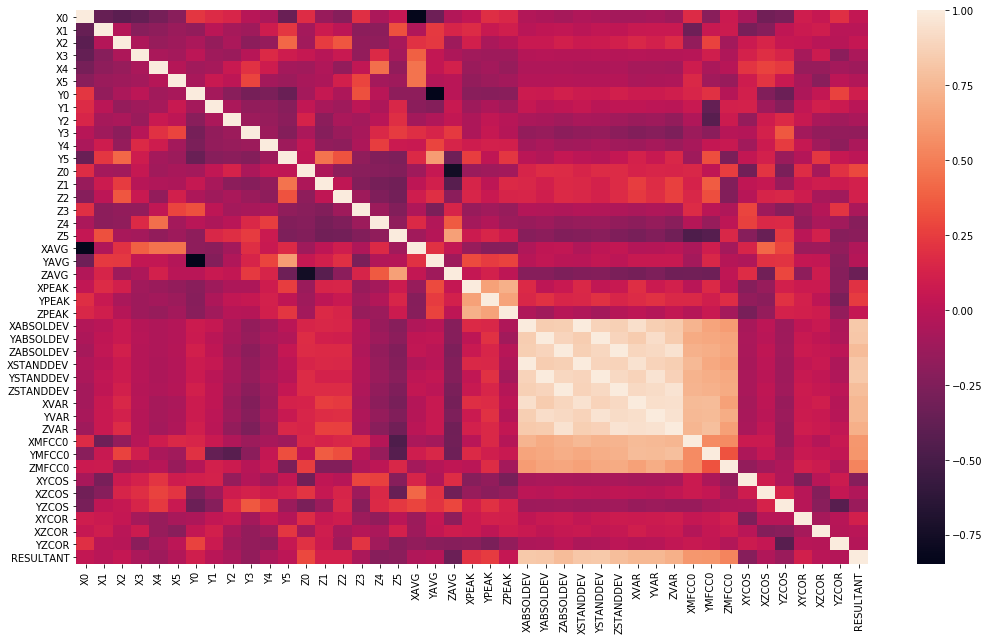

In [17]:
fig, ax = plt.subplots(figsize=(15,9))
sns.color_palette("hls", 8)
heat_map = sns.heatmap(reducedSubjects_phone_accel1.corr())

save_fig("Matrice de corrélation inter-attributs")

plt.show()

Cette carte de chaleur représente la corrélation entre les différents attributs. On voit rapidement que les attributs XABSOLDEV à ZVAR sont tous très corrélés entre eux. Il pourrait être intéressant de ne garder qu'un seul de ces attributs (XABSOLDEV par exemple) et regarder l'impact sur les performances du classifieur.

In [18]:
attributes3=['YABSOLDEV','ZABSOLDEV','XSTANDDEV','YSTANDDEV','ZSTANDDEV','XVAR','YVAR','ZVAR']
not_relevant_features["correlated"]=attributes3

Saving figure Histogramme des données réduit 2


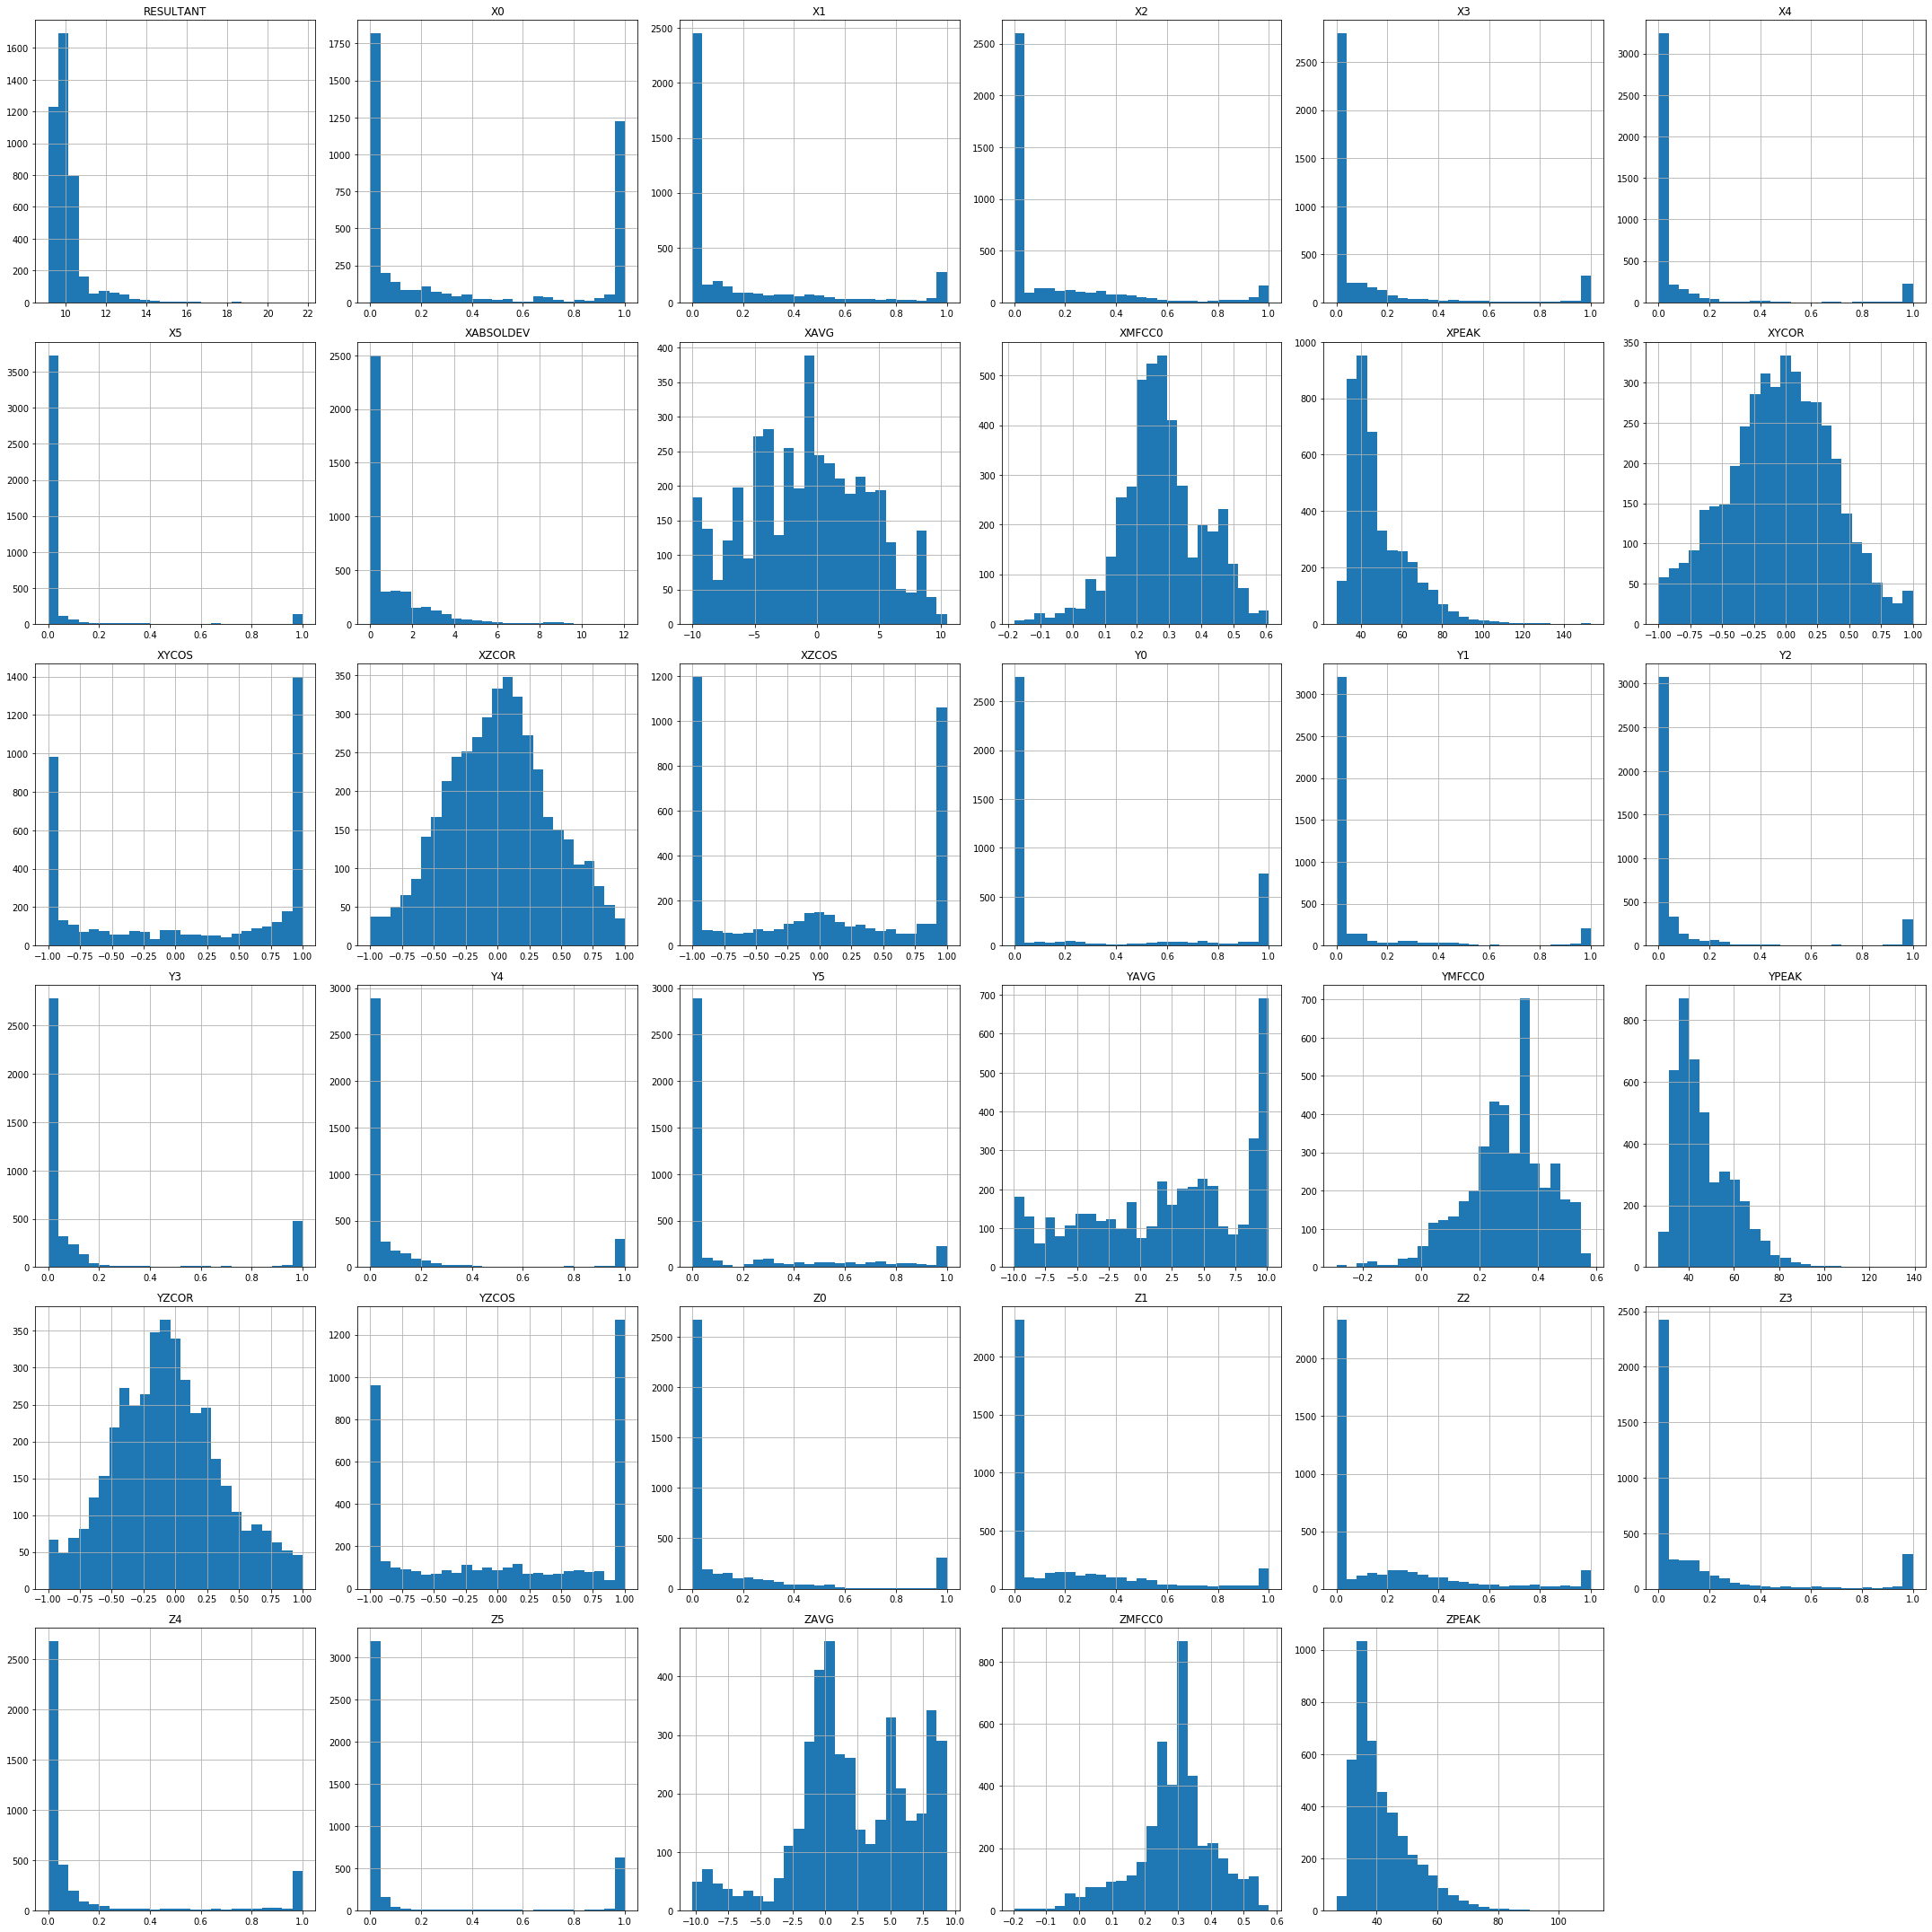

In [19]:
reducedSubjects_phone_accel2 = reducedSubjects_phone_accel1.drop(attributes3, axis=1)
reducedSubjects_phone_accel2.hist(bins = 25, figsize=(30,30))
save_fig("Histogramme des données réduit 2")
plt.show()

### Corrélation entre les données des différents capteurs et appareils

In [20]:
subject1600_phone_accel = load_wisdm_data(1600, 'phone', 'accel')
subject1600_phone_gyro = load_wisdm_data(1600, 'phone', 'gyro')
subject1600_watch_accel = load_wisdm_data(1600, 'watch', 'accel')
subject1600_watch_gyro = load_wisdm_data(1600, 'watch', 'gyro')
corrThreshold=0.7

#### Corrélation entre les appareils

In [21]:
corr1=subject1600_watch_gyro.corrwith(subject1600_watch_accel, axis = 0).sort_values(ascending=False)
corr1=corr1**2
corr1[corr1>corrThreshold]

RESULTANT    0.882482
YMFCC4       0.816684
YMFCC12      0.816684
YMFCC10      0.816684
YMFCC2       0.816684
YMFCC0       0.816684
YMFCC9       0.816684
YMFCC3       0.816684
YMFCC5       0.816684
YMFCC7       0.816684
YMFCC6       0.816684
YMFCC1       0.816684
YMFCC11      0.816684
YMFCC8       0.816684
XVAR         0.768006
XSTANDDEV    0.711269
XABSOLDEV    0.707384
dtype: float64

In [22]:
corr2=subject1600_phone_gyro.corrwith(subject1600_phone_accel, axis = 0).sort_values(ascending=False)
corr2=corr2**2
corr2[corr2>corrThreshold]

ZVAR         0.900846
XVAR         0.895959
ZSTANDDEV    0.894419
XSTANDDEV    0.865132
ZABSOLDEV    0.842352
XABSOLDEV    0.800665
RESULTANT    0.785973
YVAR         0.765130
dtype: float64

Ces attributs corrélés pourraient être retirés (pour un appareil) pour voir l'impact sur la classification.

#### Corrélation entre les capteurs

In [23]:
corr3=subject1600_watch_accel.corrwith(subject1600_phone_accel, axis = 0).sort_values(ascending=False)
corr3=corr3**2
corr3[corr3>corrThreshold]

Series([], dtype: float64)

In [24]:
corr4=subject1600_watch_gyro.corrwith(subject1600_phone_gyro, axis = 0).sort_values(ascending=False)
corr4=corr4**2
corr4[corr4>corrThreshold]

Series([], dtype: float64)

Il n'y a pas d'attributs avec une grande corrélation pour les données du capteur.

In [25]:
from sklearn import tree
import graphviz 

features_to_drop=not_relevant_features["similar"]
features_to_drop=features_to_drop+['ACTIVITY','class']

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)

feature_names = list(X.columns)
target_names=y.unique()

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

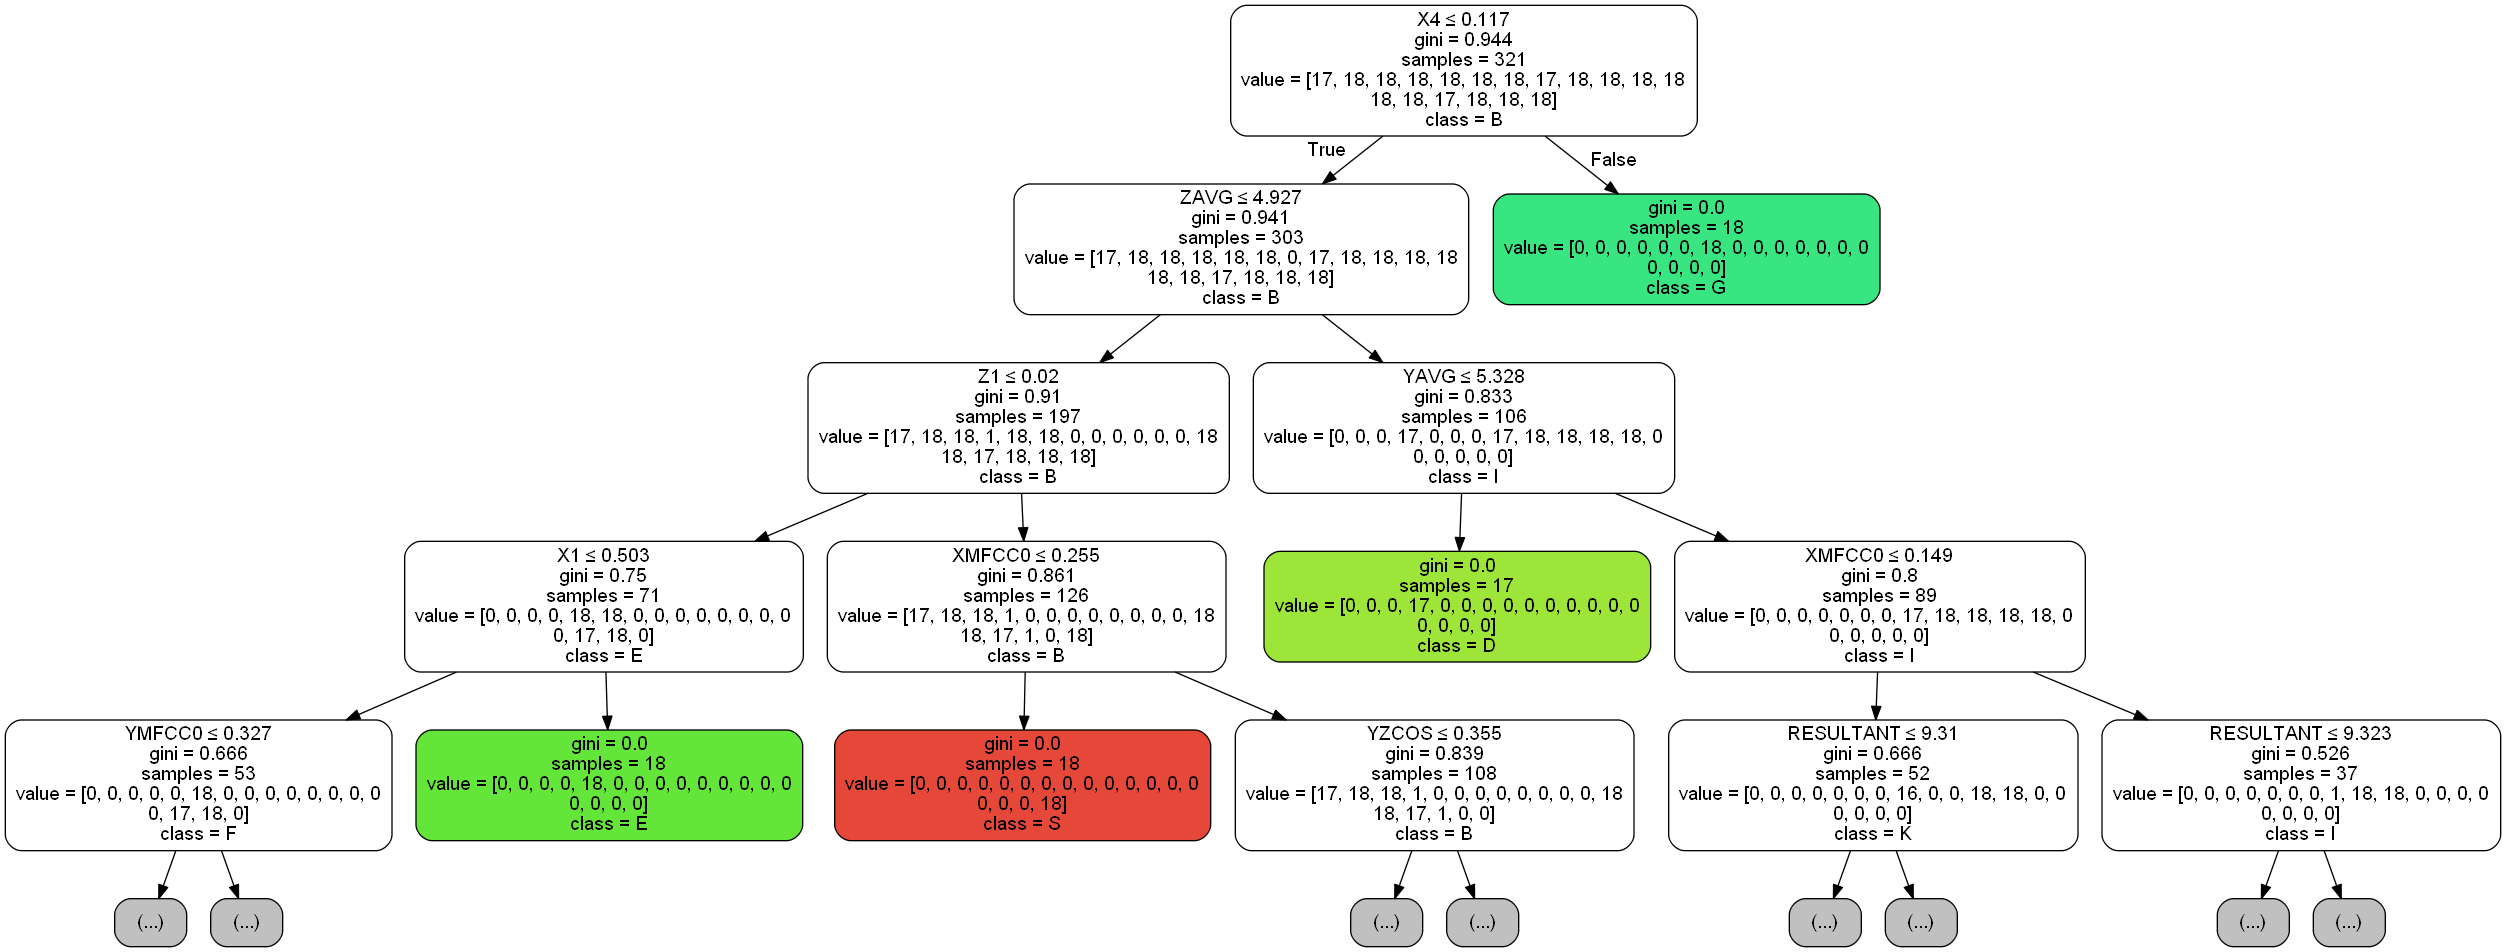

In [26]:
#Arbre entier
dot_tree = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)

graph_tree = graphviz.Source(dot_tree)

png_bytes = graph_tree.pipe(format='png')
path=os.path.join(IMAGES_PATH,'Arbre de décision.png')
with open(path,'wb') as f:
    f.write(png_bytes)
f.close()

#Arbre réduit à une profondeur de quatre
dot_reducted_tree = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True, max_depth=4)  

graph_reducted_tree = graphviz.Source(dot_reducted_tree)

png_bytes = graph_reducted_tree.pipe(format='png')
path=os.path.join(IMAGES_PATH,'Arbre de décision réduit.png')
with open(path,'wb') as f:
    f.write(png_bytes)
f.close()

from IPython.display import Image
Image(png_bytes)

Les attributs les plus importants sont ceux qui sont le plus proches de la racine de l'arbre. On peut donc se dire que les attributs ZAVG,Z1 et ZMFCC0 sont des attributs importants pour le sujet 1600 et l'accéléromètre du téléphone. On va compléter l'analyse avec une forêt d'arbres de décision.

Feature ranking:


,feature_number,feature_name,importance
0,30,XAVG,0.0545
1,32,ZAVG,0.0478
2,2,X2,0.0474
3,46,YMFCC0,0.0464
4,31,YAVG,0.0439
5,45,XMFCC0,0.0396
6,3,X3,0.0388
7,24,Z4,0.0370
8,47,ZMFCC0,0.0370
9,54,RESULTANT,0.0318


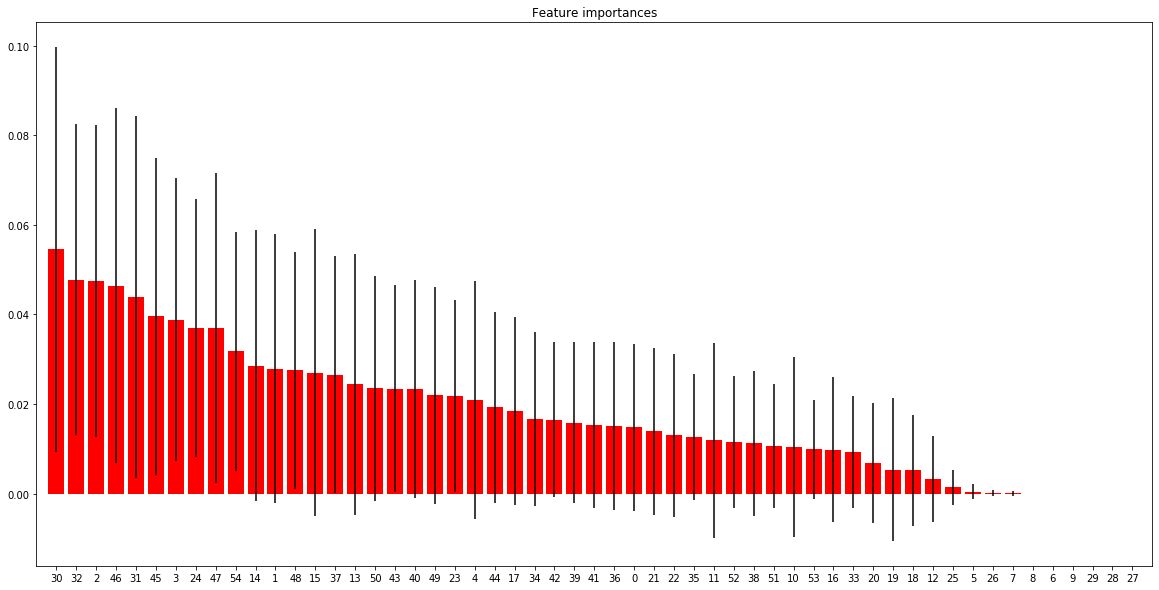

In [27]:
from sklearn.ensemble import ExtraTreesClassifier

features_to_drop=not_relevant_features["similar"]
features_to_drop=features_to_drop+['ACTIVITY','class']

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)

forest.fit(X, y)

# Plot the feature importances of the forest
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

df=pd.DataFrame()
df['feature_number']=indices
df['feature_name']=X.columns[indices]
df['importance']=importances[indices]
df['importance']=df['importance'].map('{:,.4f}'.format)
display(df)

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Attributs classés par ordre d'importance avec la variance de chacun pour le sujet 1600. La forêt d'arbre montre effectivement que les attributs ZAVG et ZMFCC0 important mais Z1 beaucoup moins. Le cas général (c-a-d la forêt d'arbre) donne plus d'informations sur la qualité des attributs.

Optimal number of features : 16


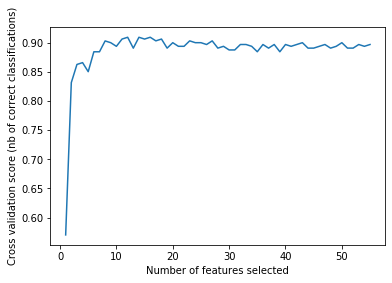

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=forest, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

On voit que le nombre optimal d'attributs est de 12 pour le sujet 1600 et l'accéléromètre du téléphone. On voit aussi qu'après 10 attributs la précision du modèle est plutôt constante.

Feature ranking:


,feature_number,feature_name,importance
0,30,XAVG,0.0642
1,31,YAVG,0.0544
2,54,RESULTANT,0.0511
3,46,YMFCC0,0.0478
4,32,ZAVG,0.0474
5,45,XMFCC0,0.0440
6,47,ZMFCC0,0.0386
7,48,XYCOS,0.0331
8,20,Z0,0.0300
9,21,Z1,0.0287


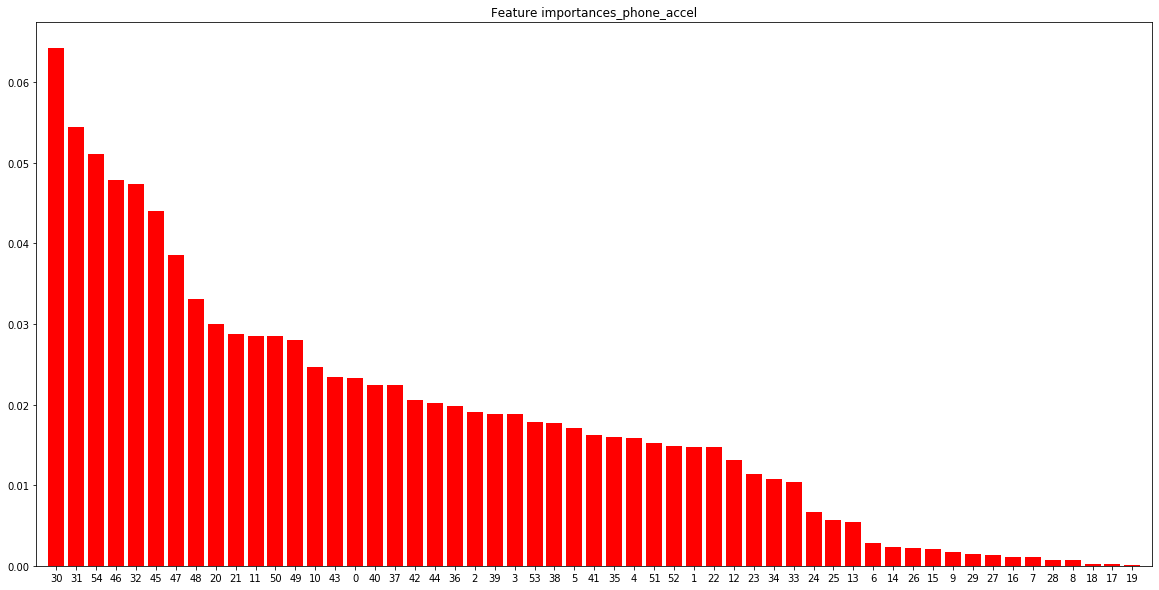

Feature ranking:


,feature_number,feature_name,importance
0,30,XAVG,0.0463
1,2,X2,0.0323
2,48,XYCOS,0.0318
3,0,X0,0.0313
4,47,ZMFCC0,0.0302
5,54,RESULTANT,0.0288
6,31,YAVG,0.0285
7,25,Z5,0.0283
8,32,ZAVG,0.0277
9,37,YABSOLDEV,0.0270


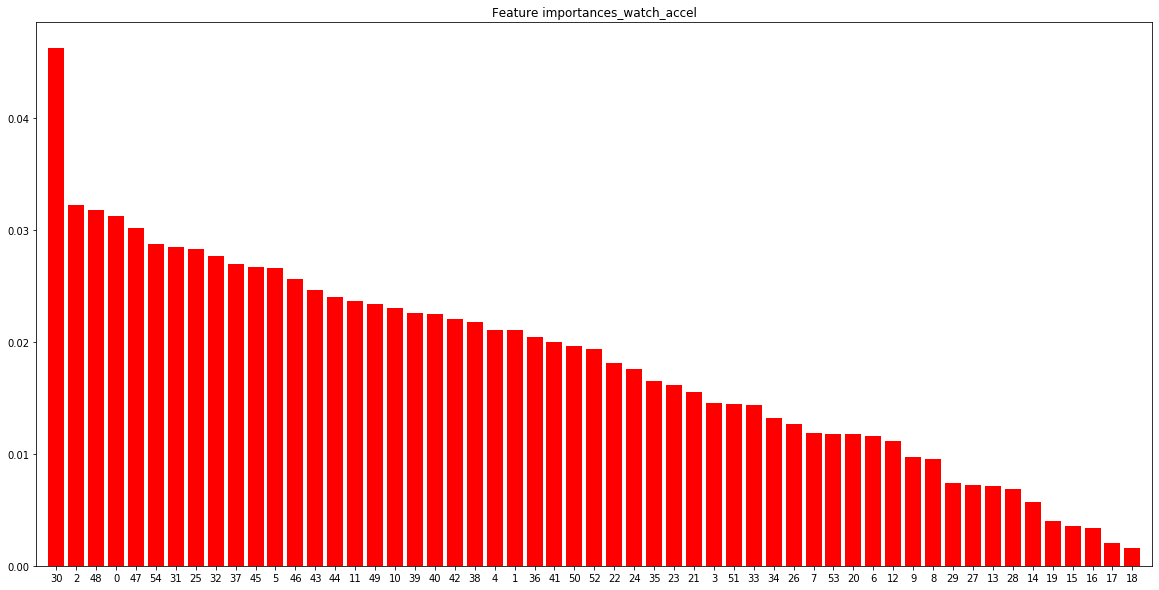

Feature ranking:


,feature_number,feature_name,importance
0,37,YABSOLDEV,0.0420
1,38,ZABSOLDEV,0.0416
2,46,YMFCC0,0.0398
3,44,ZVAR,0.0385
4,54,RESULTANT,0.0382
5,40,YSTANDDEV,0.0378
6,43,YVAR,0.0376
7,41,ZSTANDDEV,0.0339
8,33,XPEAK,0.0330
9,49,XZCOS,0.0324


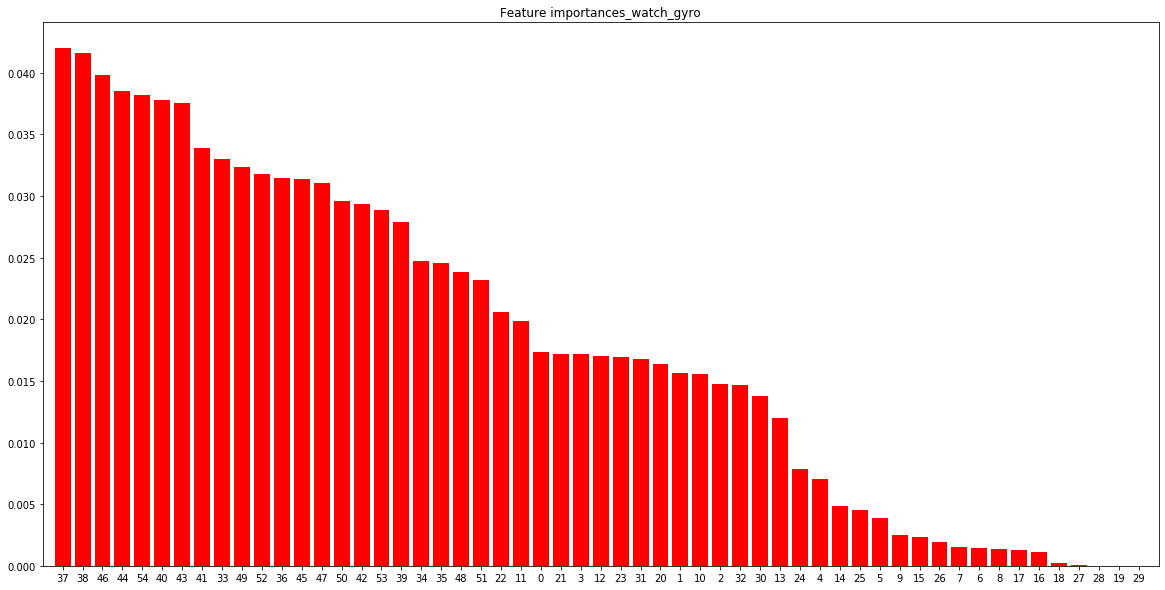

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

globalImportances = np.array([])
features_to_drop=not_relevant_features["similar"]
features_to_drop=features_to_drop+['ACTIVITY','class']
importances_by_device={}

for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        if(not(device=='phone' and sensor=='gyro')):
            for subjectId in SUBJECTSID:
                forest = ExtraTreesClassifier(n_estimators=100,
                                  random_state=0)

                subject = load_wisdm_data(subjectId, device, sensor)
                y=subject['ACTIVITY']
                X=subject.drop(features_to_drop, axis=1)

                forest.fit(X, y)


                importances = forest.feature_importances_

                #mean of importances
                if(len(globalImportances)==0):
                    globalImportances = importances
                else:
                    globalImportances = (globalImportances + importances) / 2.0

            indices = np.argsort(globalImportances)[::-1]

            #Les attributs restant triés par ordre d'importance
            SORTED_FEATURES=X.columns[indices]

            # Print the feature ranking
            print("Feature ranking:")

            df=pd.DataFrame()
            df['feature_number']=indices
            df['feature_name']=X.columns[indices]
            df['importance']=globalImportances[indices]
            df['importance']=df['importance'].map('{:,.4f}'.format)
            display(df)
            importances_by_device[device+'_'+sensor]=df

            # Plot the feature importances of the forest
            plt.figure(figsize=(20,10))
            plt.title("Feature importances"+'_'+device+'_'+sensor)
            plt.bar(range(X.shape[1]), globalImportances[indices],
                   color="r", align="center")
            plt.xticks(range(X.shape[1]), indices)
            plt.xlim([-1, X.shape[1]])
            plt.show()

On voit ici quels sont les attributs les plus importants en moyenne, pour tous les sujets selon les appareils et les capteurs. Il sera intéressant de voir commment évolue la performance des classificateurs en fonction du nombre d'attributs conservés. On peut voir que les attributs qui ont peut de dispersion X{6-9} Y{6-9} Z{6-9} sont effectivement les attributs les moins importants puisque situés en fin de liste.

## Modélisation

### SVM holdout

#### Sans enlever les features

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import svm

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(['ACTIVITY','class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8604651162790697

#### En enlevant toutes les features non pertinentes

In [31]:
features_to_drop=not_relevant_features["correlated"]+not_relevant_features["similar"]+not_relevant_features["low_variance"]
features_to_drop=features_to_drop+['ACTIVITY','class']

In [32]:
y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8449612403100775

#### En enlevant seulement les features similaires et avec peu de variance et en gardant les features corrélées

In [33]:
features_to_drop=not_relevant_features["similar"]+not_relevant_features["low_variance"]
features_to_drop=features_to_drop+['ACTIVITY','class']

In [34]:
y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8604651162790697

Les attributs similaires et avec peu de variance n'affecte pas les performance de classification, il à était judicieux de les retirer. Cependant les attributs corrélés impactent les performances de la classifications lorsqu'on les retire. On pourra enlever systématiquement les attributs similaires et avec peu de variance pour la suite

### SVM cross-validation

In [35]:
features_to_drop=not_relevant_features["similar"]+not_relevant_features["low_variance"]
features_to_drop=features_to_drop+['ACTIVITY','class']

In [36]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.17)


### SVM GridSearch avec cross-validation

In [37]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
#ignore the sklearn  warnings : Precision is ill-defined and being set to 0.0 in labels with no predicted samples

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['accuracy','precision_macro', 'recall_macro']

best_params = {}

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, cv=5, scoring='%s' % score, iid=False, n_jobs=4
    )
    clf.fit(X_train, y_train)
    
    if(score=='accuracy'):
        best_params['GS'] = clf.best_params_

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
warnings.filterwarnings('always')

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.412 (+/-0.104) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.156 (+/-0.073) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.688 (+/-0.138) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.417 (+/-0.075) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.807 (+/-0.099) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.688 (+/-0.108) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.854 (+/-0.078) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.828 (+/-0.119) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.854 (+/-0.054) for {'C': 1, 'kernel': 'linear'}
0.875 (+/-0.075) for {'C': 10, 'kernel': 'linear'}
0.860 (+/-0.040) for {'C': 100, 'kernel': 'linear'}
0.860 (+/-0.040) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full eva

On a ici les performances suivant le score que l'on veut optimiser. On va par la suite chercher à optimiser le score de précision.

### SVM Random Grid Search

In [38]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import warnings
import scipy
warnings.filterwarnings('ignore')
#ignore the sklearn  warnings : Precision is ill-defined and being set to 0.0 in labels with no predicted samples

y=subject1600_phone_accel['ACTIVITY']
X=subject1600_phone_accel.drop(features_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


tuned_parameters = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
                     'kernel': ['rbf','linear'], 'class_weight':['balanced', None]}

score = 'accuracy'
print("# Tuning hyper-parameters for %s" % score)
print()

n_iter_search=50
clf=RandomizedSearchCV(SVC(),tuned_parameters, n_iter=n_iter_search, cv=5, scoring='%s' % score, n_jobs=4,random_state=0) 

clf.fit(X_train, y_train)
best_params['RandomGS'] = clf.best_params_

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
# print("Grid scores on development set:")
# print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()
warnings.filterwarnings('always')

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 9.116102911900049, 'class_weight': None, 'gamma': 0.04592481411779334, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       0.70      1.00      0.82         7
           B       0.89      0.89      0.89         9
           C       1.00      0.67      0.80         6
           D       1.00      1.00      1.00        10
           E       1.00      1.00      1.00         4
           F       1.00      1.00      1.00         8
           G       1.00      1.00      1.00         5
           H       0.78      0.88      0.82         8
           I       0.70      0.78      0.74         9
           J       0.86      0.67      0.75         9
           K       1.00      1.00      1.00         5
           L       0.71      0

Cette recherche par grille aléatoire est une autre méthode d'obtention de recherche de paramètres. Cette technique est intéressante mais ne sera pas utilisé par la suite.

### Recherche de meilleurs paramètres sur tous les sujets avec SVM

In [39]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

bestParams_report1={}
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        bestParams = pd.DataFrame(columns=['C','kernel'])
        if(not(device=='phone' and sensor=='gyro')):
            for subjectId in SUBJECTSID:
                
                subject = load_wisdm_data(subjectId, device, sensor)
                y=subject['ACTIVITY']
                X=subject.drop(features_to_drop, axis=1)
                

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

                tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                                     'C': [1, 10, 100, 1000]},
                                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

                score = 'accuracy'

                clf = GridSearchCV(
                    SVC(), tuned_parameters, cv=5, scoring='%s' % score, n_jobs=4
                )
                clf.fit(X_train, y_train)
                
                params=clf.best_params_
                bestParams=bestParams.append(params, ignore_index=True)
            bestParams_report1[device+'_'+sensor]=bestParams
                

In [40]:
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        if(not(device=='phone' and sensor=='gyro')):
            print(device+'_'+sensor)
            dups = bestParams_report1[device+'_'+sensor].pivot_table(index=['C','kernel'], aggfunc='size')
            print(dups)
            print()

phone_accel
C     kernel
1     linear    16
10    linear    13
100   linear     9
      rbf        2
1000  linear     3
      rbf        7
dtype: int64

watch_accel
C     kernel
1     linear    10
10    linear     5
      rbf        5
100   rbf       19
1000  linear     1
      rbf       10
dtype: int64

watch_gyro
C     kernel
1     linear    14
10    linear    19
100   linear    12
1000  rbf        5
dtype: int64



On s'aperçoit que le noyau est important selon le capteur que l'on utilise. On décidera alors d'utilisé les noyaux suivants :
- linear pour l'accéléromètre du téléphone
- rbf pour l'accéléromètre de la montre
- linear pour le gyroscope de la montre

In [41]:
bestParams_report2={}
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        bestParams = pd.DataFrame(columns=['C','kernel'])
        if(not(device=='phone' and sensor=='gyro')):
            for subjectId in SUBJECTSID:
                
                subject = load_wisdm_data(subjectId, device, sensor)
                y=subject['ACTIVITY']
                X=subject.drop(features_to_drop, axis=1)
                

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
                if(device=='watch' and sensor=='accel'):
                     tuned_parameters = {'kernel': ['rbf'], 'C': [1, 10, 100, 1000]}
                else:
                    tuned_parameters = {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
                
                score = 'accuracy'

                clf = GridSearchCV(
                    SVC(), tuned_parameters, cv=5, scoring='%s' % score, n_jobs=4
                )
                clf.fit(X_train, y_train)
                
                params=clf.best_params_
                bestParams=bestParams.append(params, ignore_index=True)
            bestParams_report2[device+'_'+sensor]=bestParams

In [42]:
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        if(not(device=='phone' and sensor=='gyro')):
            print(device+'_'+sensor)
            dups = bestParams_report2[device+'_'+sensor].pivot_table(index=['C','kernel'], aggfunc='size')
            print(dups)
            print()

phone_accel
C     kernel
1     linear    24
10    linear    14
100   linear     9
1000  linear     3
dtype: int64

watch_accel
C     kernel
100   rbf       17
1000  rbf       33
dtype: int64

watch_gyro
C    kernel
1    linear    15
10   linear    22
100  linear    13
dtype: int64



On retiendra les paramètres qui apparaissent le plus souvent pour chaque capteurs pour l'élaboration des modèles
- Téléphone et accéléromètre : C=1 et kernel = linear
- Montre et accéléromètre : C = 1000 et kernel = rbf
- Montre et gyroscope : C = 10 et kernel = linear

### Résultat finaux pour SVM

In [43]:
features_to_drop=not_relevant_features["similar"]+not_relevant_features["low_variance"]
features_to_drop=features_to_drop+['ACTIVITY','class']

In [44]:
final_report_SVM_SVM={}
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        scores=np.array([])
        if(not(device=='phone' and sensor=='gyro')):
            if(sensor=='accel' and device=='phone'):
                    kernel='linear'
                    C=1
            if(sensor=='accel' and device=='watch'):
                    kernel='rbf'
                    C=1000
            if(sensor=='gyro' and device=='watch'):
                    kernel='linear'
                    C=10
                    
            for subjectId in SUBJECTSID:
                subject = load_wisdm_data(subjectId, device, sensor)
                y=subject['ACTIVITY']
                X=subject.drop(features_to_drop, axis=1)
                
                clf = svm.SVC(kernel=kernel, C=C)
                scores = np.append(scores,cross_val_score(clf, X, y, cv=10))
            final_report_SVM[device+'_'+sensor]=[round(scores.mean(),2),round(scores.std()*2,2)]

In [45]:
print("Accuracy :")
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        if(not(device=='phone' and sensor=='gyro')):
            print(device+'_'+sensor+' : '+
                  str(final_report_SVM[device+'_'+sensor][0])+
                  ' +/- '+
                  str(final_report_SVM[device+'_'+sensor][1]))

Accuracy :
phone_accel : 0.88 +/- 0.24
watch_accel : 0.87 +/- 0.21
watch_gyro : 0.75 +/- 0.25


### Résultats finaux pour NB

In [46]:
from sklearn.naive_bayes import GaussianNB

final_report_NB={}
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        scores=np.array([])
        if(not(device=='phone' and sensor=='gyro')):
            if(sensor=='accel' and device=='phone'):
                    kernel='linear'
                    C=1
            if(sensor=='accel' and device=='watch'):
                    kernel='rbf'
                    C=1000
            if(sensor=='gyro' and device=='watch'):
                    kernel='linear'
                    C=10
                    
            for subjectId in SUBJECTSID:
                subject = load_wisdm_data(subjectId, device, sensor)
                y=subject['ACTIVITY']
                X=subject.drop(features_to_drop, axis=1)
                
                clf = GaussianNB()
                scores = np.append(scores,cross_val_score(clf, X, y, cv=10))
            final_report_NB[device+'_'+sensor]=[round(scores.mean(),2),round(scores.std()*2,2)]

In [49]:
print("Accuracy :")
for device in ['phone','watch']:
    for sensor in ['accel','gyro']:
        if(not(device=='phone' and sensor=='gyro')):
            print(device+'_'+sensor+' : '+
                  str(final_report_NB[device+'_'+sensor][0])+
                  ' +/- '+
                  str(final_report_NB[device+'_'+sensor][1]))

Accuracy :
phone_accel : 0.79 +/- 0.27
watch_accel : 0.86 +/- 0.26
watch_gyro : 0.75 +/- 0.27
